## Imports and Installation

In [1]:
!pip install miseval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.9 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 55.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 39.7 MB/s eta 0:00:0000:0100:01
  Created wheel for dictances: filename=dictances-1.5.6-py3-none-any.whl size=13517 sha256=78f8a025fe63f01cbee993d09d47b396660cda50732fad4c407d8a278b539cfb
  Stored in directory: /root/.cache/pip/wheels/cc/96/4d/91f2edcb5d2584367af01e025c786759fffe618127f10eadbd
  Created wheel for hausdorff: filename=hausdorff-0.2.6-py3-none-any.whl size=15187 sha256=7369bd541aaa6abedb609b80a788035f8e58b4bea246aa8a1778d411f564449a
  Stored in directory: /root/.cache/pip/wheels/8d/56/ea/fd4bbacf1217e197e63de821a74730e953b23fdf2030733061
  C

In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 kB 42.4 MB/s eta 0:00:00


In [3]:
!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 61.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=1bf479d3d4f390632824f605dc303d7fae72011f3fca5bf9b80eaa8d5142e13b
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=e440f8cef6fd36ca9f843d99e051bbd2927740b7d94671750ece5aa930796444
  Stored in directory: /root/.cache/pip/wheels/d1/3b/4e/2f3015f1ab76f34be28e04c4bcee27e8cabfa70d2eadf8bc3b
Successfully built efficientnet-pytorch pretrainedmodels


In [4]:
#Standard imports
import os
import math
import pathlib
import shutil
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.ndimage import rotate
import re
import random
#import segmentation_models as sm
#import segmentation_models_pytorch as sm
import time
from sklearn.model_selection import train_test_split
from miseval import evaluate
from tqdm import tqdm
from PIL import Image
#Tensorflow imports
#import tensorflow as tf
#from tensorflow import keras
#from tensorflow.keras import layers
#from tensorflow.keras.utils import image_dataset_from_directory, img_to_array, load_img, array_to_img, save_img, to_categorical



In [5]:
#PyTorch imports
import torch
from torch.utils.data import TensorDataset, Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as F
import segmentation_models_pytorch as smp
from torchvision import transforms
from torch import nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Paths

In [6]:
image_dir = "./fundus_images/"
annotations_dir = "./cleaned_annotations/"

In [7]:
image_files = sorted(list(os.listdir(image_dir)))
image_files.remove(".ipynb_checkpoints")
image_files = sorted([os.path.join(image_dir, file_name) for file_name in image_files])


annotation_files = sorted(list(os.listdir(annotations_dir)))
annotation_files.remove(".DS_Store")
annotation_files = sorted([os.path.join(annotations_dir, file_name) for file_name in annotation_files])

In [8]:
train_img, tv_img, train_anns, tv_anns = train_test_split(image_files, annotation_files, test_size=0.2, random_state=99)

In [9]:
mismatch = [file[:-4] for file in image_files if file in annotation_files]

In [10]:
valid_img, test_img, valid_anns, test_anns = train_test_split(tv_img, tv_anns, test_size=0.5, random_state=99)

In [11]:
print(f"There are {len(train_img)} training images and annotations")
print(f"There are {len(valid_img)} validation images and annotations")
print(f"There are {len(test_img)} test images and annotations")

There are 1260 training images and annotations
There are 157 validation images and annotations
There are 158 test images and annotations


## Data Pipeline Classes

In [12]:
class MultiClassSegmentationDataset(Dataset):
    
    def __init__(self, image_files, mask_dirs, size, classes,n_classes, background=True, test_mode=False):
        
        assert len(image_files) == len(mask_dirs)
        
        self.image_files = sorted(image_files)
        self.mask_dirs = sorted(mask_dirs)
        self.annotation_files = {}
        
        for img_fldr in self.mask_dirs:
            self.annotation_files[img_fldr] = sorted(os.listdir(img_fldr))
            
        self.H = size
        self.W = size
        self.n = n_classes
        self.classes = dict(zip(sorted(classes), range(n_classes)))
        self.background = background
        self.test_mode = test_mode

    
    def __len__(self):
        
        return len(self.image_files)

    def __getitem__(self, idx):
        
        #Reading the image
        img_path = self.image_files[idx]

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.H,self.W))
        #norm_img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        norm_img = img / 255.0
        norm_img = np.transpose(norm_img, (2, 0, 1))
        img_tensor = torch.from_numpy(norm_img)
        img_tensor = img_tensor.float()
        
        
        #Preparing mask - There are 4 lesion classes, the directories have 1 picture each for a specific lesion, have to combine them
        #1 extra class for the background
        #The background mask is currently all ones, the ones from each class have to be subtracted from it
        background = np.ones((self.H, self.W))
        mask = np.zeros((self.n + 1, self.H, self.W))
        ann_fldr = self.mask_dirs[idx]
        ann_files = self.annotation_files[ann_fldr]
        for ann_file in ann_files:

            code = ann_file[:-4]
            ix = self.classes[code]
            ann_path = os.path.join(ann_fldr, ann_file)
            ann = cv2.imread(ann_path, 0)
            ann = cv2.resize(ann, (self.H, self.W), cv2.INTER_NEAREST)
            #update background by subtracting the current pixel positions
            background = background - ann
            
            ann = np.expand_dims(ann, axis=0)
            
            mask[ix+1, :, :] = ann
        
        #If there are overlapping pixel values, the pixel value at a certain position may be negative, have to clip to 0
        background = np.clip(background, 0, None)
        background = np.expand_dims(background, axis=0)
        #Place the background class inside
        if self.background:
            mask[0,:,:] = background
        
        mask_tensor = torch.from_numpy(mask)
        mask_tensor = mask_tensor.float()
        
        if not self.test_mode:
            #Data augmentation if it's not test_mode, for example training and validation data will get augmented
            augment_mode = np.random.randint(0,4)
            if augment_mode == 0:
                img_tensor = F.hflip(img_tensor)
                mask_tensor = F.hflip(mask_tensor)
            elif augment_mode == 1:
                img_tensor = F.vflip(img_tensor)
                mask_tensor = F.vflip(mask_tensor)
            elif augment_mode == 2:
                angle = np.random.randint(-5, 5)
                img_tensor = F.rotate(img_tensor, angle)
                mask_tensor = F.rotate(mask_tensor, angle)

            
        return img_tensor, mask_tensor
        
        
                
        
        
        
        

## Model Definition

### Base Model

In [13]:
class BaseModel():

    def predict(self, dataloader):
        """This function """
        self.eval()

        with torch.no_grad():
            
            predictions = []
            for images, _ in tqdm(dataloader):
                images = images.to(device)
                outputs = self(images)
                outputs = torch.nn.functional.softmax(outputs, dim=1)
                predictions.append(outputs.permute(0, 2, 3, 1))
            predictions = torch.cat(predictions, dim=0)
        
        return predictions.detach().cpu().numpy()
    
    def predict_image(self, image):
        """This function returns the prediction of one image"""
        self.eval()
        with torch.no_grad():
            
            image = image.unsqueeze(0)
            image = image.to(device)
            output = self(image)
            output = torch.nn.functional.softmax(output, dim=1)
            output = output.detach().cpu().numpy()
            output = np.transpose(output, (0, 2, 3, 1))
            return output

#### Decoder

In [14]:
class SimpleDecoderBlock(nn.Module):

    def __init__(self, d_in, d_out):

        super().__init__()

        self.upconv = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv_1 = nn.Conv2d(d_in, d_out, 1, 1)
        self.relu = nn.ReLU()
        self.conv_2 = nn.Conv2d(d_out*2, d_out, 3, 1, "same")
        self.bn1 = nn.BatchNorm2d(d_out)
        self.conv_3 = nn.Conv2d(d_out, d_out, 3, 1, "same")
        self.bn2 = nn.BatchNorm2d(d_out)

    def forward(self, inp, a):

        x = self.upconv(inp)
        x = self.relu(self.conv_1(x))

        if a is not None:

            x = torch.cat([a, x], axis=1)
            x = self.conv_2(x)
            x = self.bn1(x)
            x = self.relu(x)
            
        x = self.conv_3(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


        

In [15]:
class DecoderBlock(nn.Module):

    def __init__(self, d_in, d_out):


        super().__init__()
        self.upconv = nn.ConvTranspose2d(d_in, d_out, 2, 2)
        self.conv_1 = nn.Conv2d(d_out*2, d_out, 3, 1, "same")
        self.bn1 = nn.BatchNorm2d(d_out)
        self.relu = nn.ReLU()
        self.conv_2 = nn.Conv2d(d_out, d_out, 3, 1, "same")
        self.bn2 = nn.BatchNorm2d(d_out)
        

    def forward(self, inp, a):
        
        x = self.relu(self.upconv(inp))

        if a is not None:
            x = torch.cat([a, x], axis=1)
            x = self.conv_1(x)
            x = self.bn1(x)
            x = self.relu(x)
            
        x = self.conv_2(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x


class Decoder(nn.Module):

    def __init__(self, d_in, filters, num_classes, simple=False, sigmoid=False):

        super().__init__()

        self.decoder_blocks = []

        for f in filters:
            
            if simple:
                db = SimpleDecoderBlock(d_in, f)
            else:
                db = DecoderBlock(d_in, f)

            self.decoder_blocks.append(db)
            d_in = f
        
        self.dropout = nn.Dropout2d(p=0.2)
        self.output = nn.Conv2d(f, num_classes, 1, 1)
        self.decoder_blocks = nn.ModuleList(self.decoder_blocks)
        self.sig = nn.Sigmoid() if sigmoid else None
    
    def forward(self, inputs, activations):

        x = inputs
        for db, a in zip(self.decoder_blocks, activations):

            x = db(x, a)
        
        output = self.output(x)
        output = self.dropout(output)
        if self.sig is not None:
            output = self.sig(output)


        return output
        


#### Encoder

In [16]:

class EncoderBlock(nn.Module):

    def __init__(self, d_in, d_out):

        super().__init__()

        self.conv_1 = nn.Conv2d(d_in, d_out, 3, 1, "same")

        self.bn1 = nn.BatchNorm2d(d_out)
        self.bn2 = nn.BatchNorm2d(d_out)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv_2 = nn.Conv2d(d_out, d_out, 3, 1, "same")
    
    def forward(self, inputs):

        a = self.relu(self.bn1(self.conv_1(inputs)))
        a = self.relu(self.bn1(self.conv_2(a)))
        x = self.pool(a)

        return x, a


class LastEncoder(nn.Module):

    def __init__(self, d_in, d_out):

        super().__init__()
        self.conv1 = nn.Conv2d(d_in, d_out, 3, 1, "same")
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(d_out, d_out, 3, 1, "same")

    def forward(self, inputs):

        x = self.relu(self.conv2(self.relu(self.conv1(inputs))))

        return x

class FullEncoder(nn.Module):

    def __init__(self, d_in, filters):

        super().__init__()

        self.encoder_blocks = []
        for f in filters[:-1]:

            encoder = EncoderBlock(d_in, f)

            self.encoder_blocks.append(encoder)
            d_in = f
        
        self.last_encoder = LastEncoder(f, filters[-1])
        self.encoder_blocks = nn.ModuleList(self.encoder_blocks)



    def forward(self, inputs):

        activations = []
        x = inputs
        for eb in self.encoder_blocks:

            x, a = eb(x)
            activations.append(a)

        x = self.last_encoder(x)

        return x, activations

class UNet(nn.Module, BaseModel):

    def __init__(self, d_in, num_classes, filters, simple=False, sigmoid=False):

        super().__init__()
        self.encoder = FullEncoder(d_in, filters)
        self.decoder = Decoder(filters[-1], filters[:-1][::-1], num_classes, simple=simple, sigmoid=sigmoid)

    def forward(self,inputs):

        x, activations = self.encoder(inputs)

        o = self.decoder(x, activations[::-1])

        return o

### VGG U-Net

In [17]:
from torchvision.models import vgg19, VGG19_Weights


In [18]:
class VGGUNet(nn.Module, BaseModel):

    def __init__(self, num_classes, simple=False, sigmoid=False):

        super().__init__()
        
        vgg19_m = vgg19(weights=VGG19_Weights.DEFAULT)
        self.vgg = nn.Sequential(*(list(vgg19_m.children())[0][:-1]))
        for param in self.vgg.parameters():
            param.requires_grad = False
            
        self.vgg = self.vgg.to(device)
        self.activations = []

        self.filters = [512, 256, 128, 64]
        self.decoder = Decoder(self.filters[0], self.filters, num_classes, simple=simple, sigmoid=sigmoid)
    
    def getActivations(self):
        def hook(model, input, output):
            self.activations.append(output)
        return hook
    
    def forward(self, input):

        self.activations = []

        h1 = self.vgg[3].register_forward_hook(self.getActivations())
        h2 = self.vgg[8].register_forward_hook(self.getActivations())
        h3 = self.vgg[17].register_forward_hook(self.getActivations())
        h4 = self.vgg[26].register_forward_hook(self.getActivations())

        vgg_output = self.vgg(input)

        final_output = self.decoder(vgg_output, self.activations[::-1])

        h1.remove()
        h2.remove()
        h3.remove()
        h4.remove()

        return final_output


### Resnet UNet

In [19]:
from torchvision.models import resnet50, ResNet50_Weights

In [20]:
class ResNetUNet(nn.Module, BaseModel):

    def __init__(self, num_classes, simple=False, sigmoid=False):

        super().__init__()

        self.activations = [None]
        resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        self.resnet_backbone = nn.Sequential(*(list(resnet_model.children())[0:7]))
        for param in self.resnet_backbone.parameters():
            param.requires_grad = False

        filters = [512, 256, 64, 64]
        self.decoder = Decoder(1024, filters, num_classes, simple, sigmoid)
    
    def getActivations(self):
        def hook(model, input, output):
            self.activations.append(output)
        return hook
    
    def forward(self, input):

        self.activations = [None]

        hr1 = self.resnet_backbone[2].register_forward_hook(self.getActivations())
        hr2 = self.resnet_backbone[4][2].register_forward_hook(self.getActivations())
        hr3 = self.resnet_backbone[5][-1].register_forward_hook(self.getActivations())

        resnet_output = self.resnet_backbone(input)

        final_output = self.decoder(resnet_output, self.activations[::-1])

        hr1.remove()
        hr2.remove()
        hr3.remove()

        return final_output

### Efficient Net UNet

In [21]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights

In [28]:
class EfficientNetUNet(nn.Module, BaseModel):

    def __init__(self, num_classes, simple=False, sigmoid=False):

        super().__init__()
        self.activations = [None]

        effnet_b4 = efficientnet_b4(weights=EfficientNet_B4_Weights)
        self.effnet_b4_backbone = nn.Sequential(*(list(effnet_b4.children())[0]))
        for param in self.effnet_b4_backbone.parameters():
            param.requires_grad = False
        
        filters = [160, 56, 32, 48, 64]
        self.decoder = Decoder(448, filters, num_classes, simple, sigmoid)
    
    def getActivations(self):
        def hook(model, input, output):
            self.activations.append(output)
        return hook
    
    def forward(self, input):

        self.activations = [None]

        e1 = self.effnet_b4_backbone[0].register_forward_hook(self.getActivations())
        e2 = self.effnet_b4_backbone[2][-1].register_forward_hook(self.getActivations())
        e3 = self.effnet_b4_backbone[3][-1].register_forward_hook(self.getActivations())
        e4 = self.effnet_b4_backbone[5][-1].register_forward_hook(self.getActivations())
        e5 = self.effnet_b4_backbone[7][-1].register_forward_hook(self.getActivations())

        self.effnet_b4_backbone(input)
        effnet_output = self.activations.pop()

        final_output = self.decoder(effnet_output, self.activations[::-1])

        e1.remove()
        e2.remove()
        e3.remove()
        e4.remove()
        e5.remove()

        return final_output

        
        

        

## Trainer

In [23]:
class Trainer:

    def __init__(self, network, train_dl, n_classes, epochs, loss_function, optimizer, scheduler=None):

        self.network = network
        self.train_dl = train_dl
        self.epochs = epochs
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.scheduler = scheduler 
        self.n_classes = n_classes
        self.multi = True if n_classes > 1 else False

    
    def get_mins(self, seconds):
        
        """This function converts seconds to minutes and seconds"""

        return f"{math.floor(seconds // 60)} mins : {math.floor(seconds % 60)} seconds"
    
    def main_step(self, img_batch, target_batch):

        #Zeroing out previous gradients
        self.optimizer.zero_grad()

        #Make model prediction
        pred = self.network(img_batch)
        
        
        target_batch = target_batch.float().to(device)
            
        #Compute Loss

        loss = self.loss_function(pred, target_batch)
        #Calculate gradients through backpropagation
        loss.backward()            
        #Update the model parameters
        self.optimizer.step()
        
        return loss, pred
    
    def eval_step(self,img_batch, target_batch):
    
        #Assumes the network is already put into evaluation mode
        val_pred = self.network(img_batch)
        
        target_batch = target_batch.float().to(device)

        #Compute Loss

        loss = self.loss_function(val_pred, target_batch)

        return loss, val_pred
    
    def plot_sample_prediction(self, img_batch, target_batch, pred_batch, ix, background=False):
    
        """This function plots along with a sample image and annotation, the prediction for the sample image
           background : is background included in the annotations
        """
        assert self.n_classes > 0
        multi = False if self.n_classes == 1 else True
        #Initializing the softmax and the sigmoid
        softmax = nn.Softmax(dim=0)
        sigmoid = nn.Sigmoid()
        
        fig, ax = plt.subplots(1,4, figsize=(8,4))

        #Getting an image and reshaping it
        test_img = img_batch[ix]
        #Removing the image from the gpu and the computation graph
        n_img = test_img.to('cpu').detach().numpy()
        n_img = np.transpose(n_img, (1,2,0))
        H = n_img.shape[0]
        W = n_img.shape[1]
        
        #Getting the corresponding annotation
        #For multi-class it will be (C,H,W)
        #Removing the annotation from the gpu and computation graph
        test_ann = target_batch[ix]
        n_ann = test_ann.to('cpu').detach().numpy()
        if multi:
        #Making channels last for a single annotation
            n_ann = np.rollaxis(n_ann, 0, 3)
        
        #Getting the corresponding prediction
        #For multi-class it will be (C,H,W)
        test_pred = pred_batch[ix]
        if multi:
            #applying the softmax function to the prediction since they are just scores
            test_pred = softmax(test_pred)
        else:
            #applying the sigmoid function to the prediction
            test_pred = sigmoid(test_pred)
        
        #Thresholded prediction
        threshold = torch.nn.Threshold(0.75, 0)
        test_pred_clamped = threshold(test_pred)
        #For multiclass it will be (C,W,H)
        n_pred = test_pred.to('cpu').detach().numpy()
        #n_pred = np.rollaxis(n_pred, 0, 3)
        
        #For multiclass it will be (C,W,H)
        n_pred_clamped = test_pred_clamped.to("cpu").detach().numpy()
        #n_pred_clamped = np.rollaxis(n_pred_clamped, 0, 3)
        
        
        #Creating masks that can be plotted
        if (not background) and multi:
            #This step creates a mask for the background and concatenates it to the front of the annotation and prediction
            #Then the argmax operation is performed to obtain a matrix which can be plotted
            
            bg = np.full((H,W, 1), 0.1)
            n_ann = np.concatenate([bg, n_ann], axis=-1)
            n_ann = np.argmax(n_ann, axis=-1)

            n_pred = np.concatenate([bg, n_pred], axis=0)
            n_pred = np.argmax(n_pred, axis=0)
            
            n_pred_clamped = np.concatenate([bg, n_pred_clamped], axis=0)
            n_pred_clamped = np.argmax(n_pred_clamped, axis=0)
            
            
        elif background and multi:
            
            n_ann = np.argmax(n_ann, axis=-1)
            n_pred = np.argmax(n_pred, axis=0)
            n_pred_clamped = np.argmax(n_pred_clamped, axis=0)
        else:
            
            #Squeeze the annotation and the prediction since imshow expects 3 channels or just a matrix
            n_ann = np.squeeze(n_ann)
            n_pred = np.squeeze(n_pred) 
            n_pred_clamped = np.squeeze(n_pred_clamped)
        

        #Plotting the image
        ax[0].imshow(n_img)
        ax[0].axis("off")
        #Plotting the annotation
        ax[1].imshow(n_ann)
        ax[1].axis("off")
        #Plotting the prediction
        ax[2].imshow(n_pred)
        ax[2].axis("off")
        #Plotting a thresholded prediction
        ax[3].imshow(n_pred_clamped)
        ax[3].axis("off")
        plt.show()

    def plot_class_activations(self, target_batch, pred_batch):
    
        """This function plots the individual class activations given a prediction image. 
        This function assumes that the channels are first.
        This function also assumes that no softmax has been applied
        """
        
        #Reminder -- Change the test pred to soft pred and uncomment the declaration
        
        softmax = nn.Softmax(dim=0)
        
        test_pred = pred_batch[0].detach().to("cpu")
        test_ann = target_batch[0].detach().to("cpu")
        
        soft_pred = softmax(test_pred)
        soft_pred = soft_pred.detach().to("cpu").numpy()
        
        fig, ax = plt.subplots(1, self.n_classes, figsize=(self.n_classes*2, self.n_classes))
        
        for i in range(self.n_classes):
            
            ax[i].imshow(test_ann[i])
            ax[i].axis("off")
        
        fig, ax2 = plt.subplots(1, self.n_classes, figsize=(self.n_classes*2,self.n_classes))
        
        for i in range(self.n_classes):

            ax2[i].imshow(soft_pred[i])
            ax2[i].axis("off")
        plt.show()

    def fit(self, log=True, validation=False, valid_dl=None, model_checkpoint=True, model_save_path="./model.pth"):
        
        training_losses = []
        validation_losses = []

        for e in range(self.epochs):
            print(f"Starting epoch : {e+1} -------------------------------------------------------------------")
            elapsed_time = 0
            st = time.time()
            loss_value = 0
            
            #Indicates start of batch
            start = True
            start_2 = True
            total_batches = 0
            
            #Training Loop
            self.network.train()
            for img_batch, annotation_batch in self.train_dl:
                
                total_batches += 1
                #Putting the images and annotations on the device
                img_batch = img_batch.to(device)
                #Obtaining the loss and the predictions for current batch - This is multiclass classification
                loss, pred = self.main_step(img_batch, annotation_batch)
            
                #Check for the start of the batch to visualize a prediction
                if start:
                    self.plot_sample_prediction(img_batch, annotation_batch, pred, 0, background=True)
                    #Indicate that next batch is not start of epoch
                    if self.multi:
                        print(f"Plotting Activations")
                        self.plot_class_activations(annotation_batch.to(device), pred)
                    start = False
                
                #Updating loss by adding loss for current batch  
                loss_value += loss.item()
                if start_2:
                    print(f"The loss on the first batch is : {loss_value}")
                    start_2 = False
            
            #If logging is enabled print total loss value for the epoch divided by batch size
            if log:
                loss_for_epoch = round(loss_value / total_batches, 3)
                training_losses.append(loss_for_epoch)
                print(f"Loss at epoch : {e+1} : {loss_for_epoch}")

            
            #Validation Loop
            ######################################################################################################################################
            best_val_loss = float('inf')
            if validation and valid_dl is not None:

                print("Running Validation Step")
                ######### Validation step ############
                val_loss = 0
                val_start = True
                val_start_2 = True
                val_batches = 0
                with torch.no_grad():
                    self.network.eval()

                    for img_batch, annotation_batch in valid_dl:
                        
                        val_batches += 1
                        val_img_batch = img_batch.to(device)
                        valid_loss, val_pred = self.eval_step(val_img_batch, annotation_batch)
                        
                        if val_start:
                            self.plot_sample_prediction(val_img_batch, annotation_batch, val_pred, 0, background=True)
                            val_start = False

                        val_loss += valid_loss.item()

                        if val_start_2:
                            print(f"The loss on the first batch for validation is : {val_loss}")
                            val_start_2 = False


                #If logging is enabled print total loss value for the epoch divided by batch size
                if log:
                    val_loss_for_epoch = round(val_loss / val_batches, 3)
                    validation_losses.append(val_loss_for_epoch)
                    print(f"Validation Loss at epoch : {e+1} : {val_loss_for_epoch}")
                
                if val_loss_for_epoch < best_val_loss and model_checkpoint:
                    best_val_loss = val_loss_for_epoch
                    torch.save(self.network.state_dict(), model_save_path)
                
                #Modifying learning rate
                if self.scheduler is not None:
                    self.scheduler.step(val_loss_for_epoch)

                
            #End of Epoch -----------------------------------------------------------------------------------------------------------------------
            #Calculate the end time and log
            et = time.time()
            elapsed_time = et - st
            print(f"Epoch : {e+1} took {self.get_mins(elapsed_time)}")
            print("\n")
                
            ######### End of validation step #######
            print("------------------------------------------------------------------------------------------")
            print("\n")
            print("\n")
            print("\n")
        


        # Create a list of the epoch numbers
        epochs = range(1, self.epochs + 1)

        # Plot the training loss
        plt.plot(epochs, training_losses, 'r-', label='Training Loss', linewidth=2)

        # Plot the validation loss
        plt.plot(epochs, validation_losses, 'b--', label='Validation Loss', linewidth=2)

        # Set the title and labels
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

        # Add a legend
        plt.legend()
        # Show the plot
        plt.show()

                
                
                    

                    


## Loss Functions

### DiceLoss

In [24]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes, log_loss=False):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
        self.log_loss = log_loss

    def forward(self, prediction, target):
        prediction = torch.softmax(prediction, dim=1)
        prediction = prediction.view(prediction.size(0), self.num_classes, -1)
        target = target.view(target.size(0), self.num_classes, -1)
        intersection = (prediction * target).sum(dim=-1)
        union = prediction.sum(dim=-1) + target.sum(dim=-1)
        dice = 2 * intersection / union

        if self.log_loss:
            dice = torch.log(dice)

        return 1 - dice.mean()

### Cross Entropy Loss

In [25]:
class CrossEntropy4D(nn.Module):
    def __init__(self, class_weights=None):
        super(CrossEntropy4D, self).__init__()
        
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, prediction, target):
        # Reshape predictions and targets to (batch_size * height * width, num_classes)
        predictions_2d = prediction.permute(0, 2, 3, 1).reshape(-1, prediction.size()[1])
        targets_2d = target.permute(0, 2, 3, 1).reshape(-1, target.size()[1])
        loss = self.cross_entropy_loss(predictions_2d, targets_2d.argmax(1))
        return loss

### Dice CE Loss

In [26]:
class DiceCE(nn.Module):
    def __init__(self, num_classes, class_weights=None,dice_weight=1, ce_weight=1, log_dice=False):
        super(DiceCE, self).__init__()
        self.dice_loss = DiceLoss(num_classes, log_dice)
        self.ce_loss = CrossEntropy4D(weight=class_weights)
        self.dice_weight = dice_weight
        self.ce_weight = ce_weight
        
    def forward(self, prediction, target):
        dice_loss = self.dice_loss(prediction, target)
        ce_loss = self.ce_loss(prediction, target)
        return self.dice_weight*dice_loss + self.ce_weight*ce_loss

## Data Visualization and Testing

In [27]:
classes = sorted(["cotton_wool_spots", "hard_exudate", "retinal_hemorrhage", "microaneurysm"])
transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                transforms.RandomVerticalFlip(),
                                transforms.RandomRotation(degrees=5)])
train_ds = MultiClassSegmentationDataset(train_img, train_anns, size=512, classes=classes, n_classes=4)
train_dl = DataLoader(train_ds, shuffle=True, batch_size=4 ,pin_memory=True, num_workers=os.cpu_count())

valid_ds = MultiClassSegmentationDataset(valid_img, valid_anns, size=512, classes=classes, n_classes=4)
valid_dl = DataLoader(valid_ds, shuffle=True, batch_size=4 ,pin_memory=True, num_workers=os.cpu_count())

test_ds = MultiClassSegmentationDataset(test_img, test_anns, size=512, classes=classes, n_classes=4, test_mode=True)
test_dl = DataLoader(test_ds, shuffle=False, batch_size=4, pin_memory=True, num_workers=os.cpu_count())

In [24]:
x, y = next(iter(test_dl))

In [25]:
for x, y in test_dl:
    print(y.shape)
    break

torch.Size([4, 5, 512, 512])


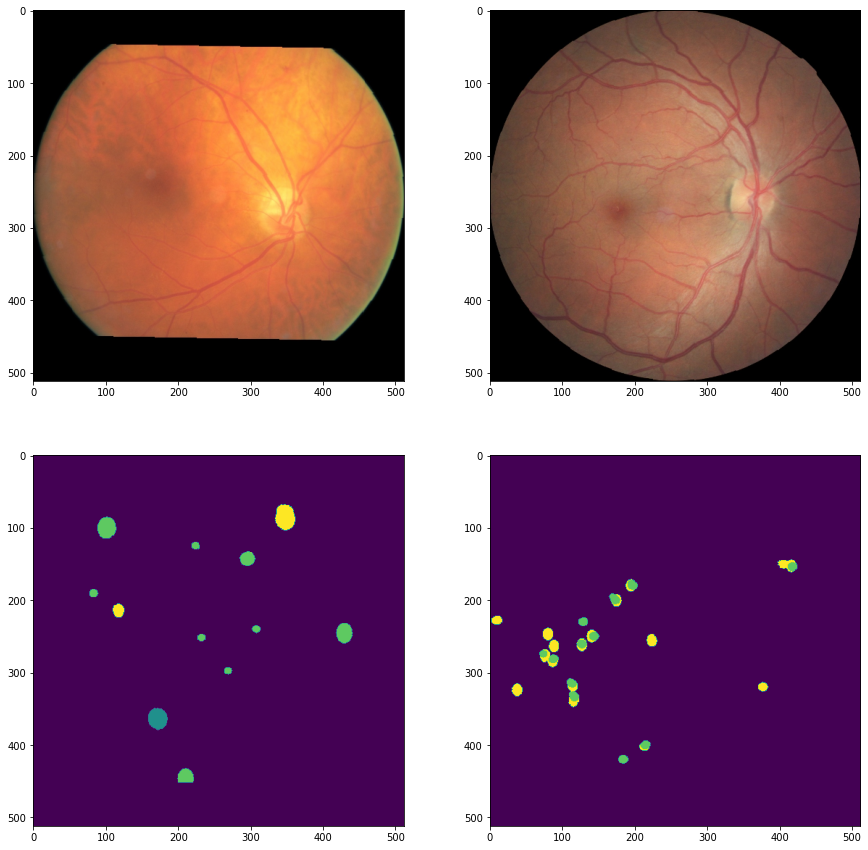

In [25]:
num_imgs = x.shape[0]
fig, ax = plt.subplots(2, num_imgs, figsize=(15, 15))

x_np = x.numpy()
y_np = y.numpy()

for i, (img, ann) in enumerate(zip(x_np, y_np)):
    
    img = np.transpose(img, (1,2,0))
    ax[0, i].imshow(img)
    ann = np.argmax(ann, axis=0)
    ax[1, i].imshow(ann)
    
plt.show()  
    

## Start of Training

### Declarations

The following will be instantiated:

- The U-Net
- The loss function
- The optimizer
- The scheduler

In [26]:
classes

['cotton_wool_spots', 'hard_exudate', 'microaneurysm', 'retinal_hemorrhage']

In [26]:
unet = UNet(3, 5, [64, 128, 256, 512, 1024], simple=False).to(device)

In [32]:
vgg_unet = VGGUNet(5, simple=True).to(device)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [28]:
res_unet = ResNetUNet(5, simple=False).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [84]:
b4_unet = EfficientNetUNet(5, simple=False).to(device)

In [33]:
pos_weight = torch.Tensor([1, 35, 7, 5, 12]).to(device)
loss_function = CrossEntropy4D(class_weights=pos_weight)
#loss_function = DiceLoss(num_classes=5)
#loss_function = DiceCE(num_classes=5, class_weights=pos_weight)
optimizer = torch.optim.Adam(vgg_unet.parameters(), lr=1.5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

In [34]:
trainer = Trainer(vgg_unet, train_dl, 5,50, loss_function, optimizer, scheduler)

Starting epoch : 1 -------------------------------------------------------------------


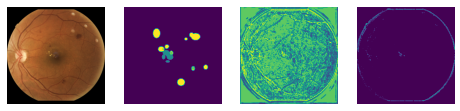

Plotting Activations


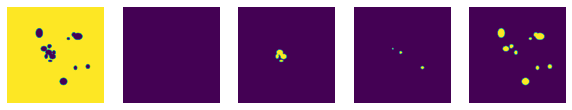

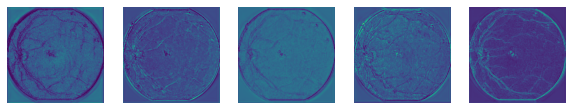

The loss on the first batch is : 1.9099795818328857
Loss at epoch : 1 : 0.992
Running Validation Step


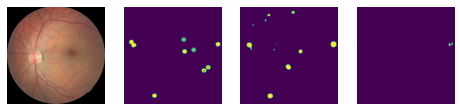

The loss on the first batch for validation is : 0.5543708801269531
Validation Loss at epoch : 1 : 0.672
Epoch : 1 took 2 mins : 16 seconds


------------------------------------------------------------------------------------------






Starting epoch : 2 -------------------------------------------------------------------


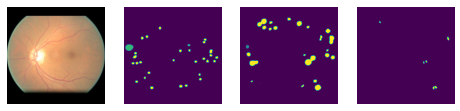

Plotting Activations


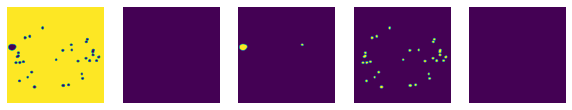

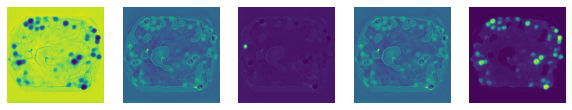

The loss on the first batch is : 0.4853138029575348
Loss at epoch : 2 : 0.677
Running Validation Step


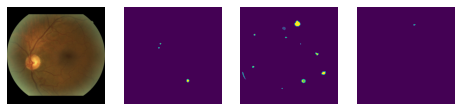

The loss on the first batch for validation is : 0.5841941237449646
Validation Loss at epoch : 2 : 0.53
Epoch : 2 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 3 -------------------------------------------------------------------


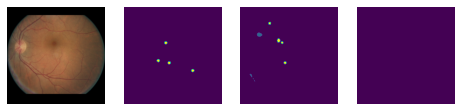

Plotting Activations


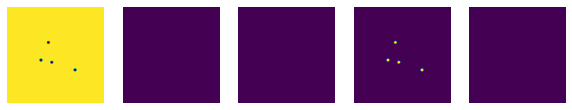

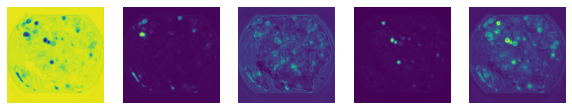

The loss on the first batch is : 0.4550481140613556
Loss at epoch : 3 : 0.581
Running Validation Step


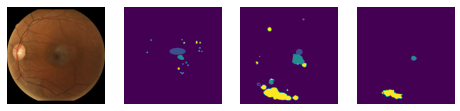

The loss on the first batch for validation is : 0.6461756825447083
Validation Loss at epoch : 3 : 0.474
Epoch : 3 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 4 -------------------------------------------------------------------


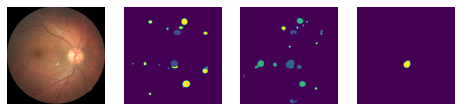

Plotting Activations


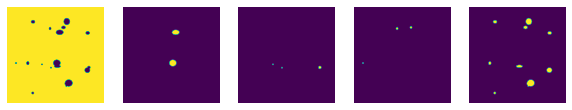

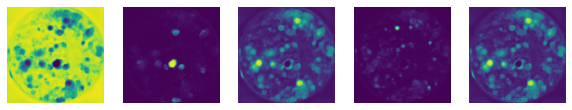

The loss on the first batch is : 0.4575366973876953
Loss at epoch : 4 : 0.564
Running Validation Step


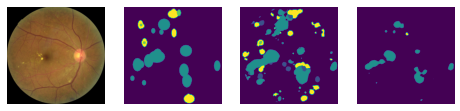

The loss on the first batch for validation is : 0.3848694860935211
Validation Loss at epoch : 4 : 0.445
Epoch : 4 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 5 -------------------------------------------------------------------


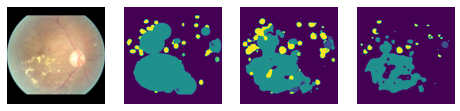

Plotting Activations


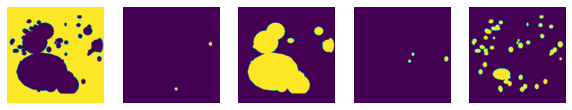

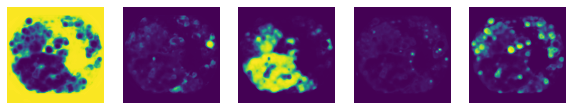

The loss on the first batch is : 0.49827849864959717
Loss at epoch : 5 : 0.527
Running Validation Step


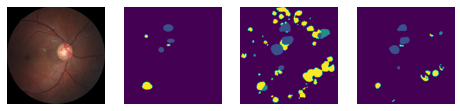

The loss on the first batch for validation is : 0.2656470835208893
Validation Loss at epoch : 5 : 0.453
Epoch : 5 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 6 -------------------------------------------------------------------


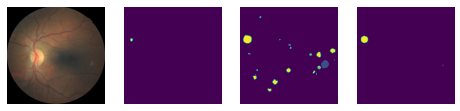

Plotting Activations


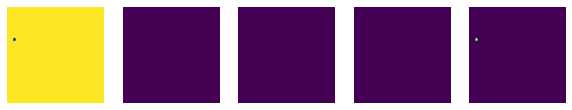

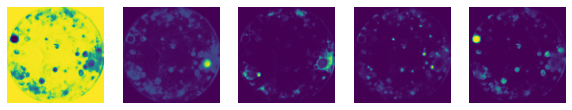

The loss on the first batch is : 0.5293015241622925
Loss at epoch : 6 : 0.517
Running Validation Step


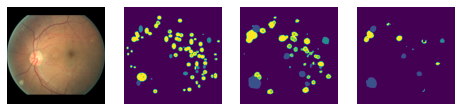

The loss on the first batch for validation is : 0.5854212641716003
Validation Loss at epoch : 6 : 0.469
Epoch : 6 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 7 -------------------------------------------------------------------


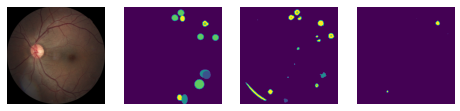

Plotting Activations


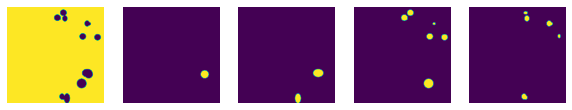

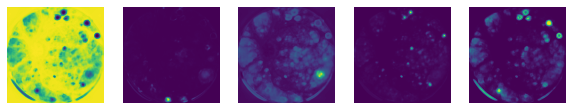

The loss on the first batch is : 0.6667670607566833
Loss at epoch : 7 : 0.497
Running Validation Step


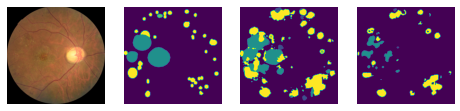

The loss on the first batch for validation is : 0.45208823680877686
Validation Loss at epoch : 7 : 0.404
Epoch : 7 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 8 -------------------------------------------------------------------


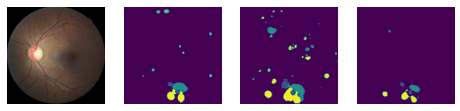

Plotting Activations


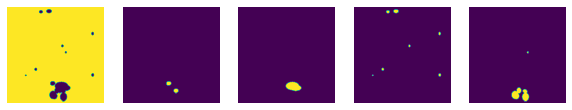

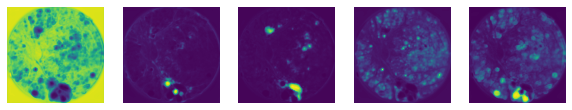

The loss on the first batch is : 0.5441781878471375
Loss at epoch : 8 : 0.482
Running Validation Step


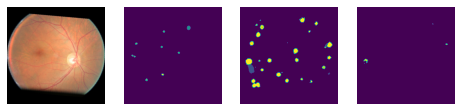

The loss on the first batch for validation is : 0.5146657824516296
Validation Loss at epoch : 8 : 0.425
Epoch : 8 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 9 -------------------------------------------------------------------


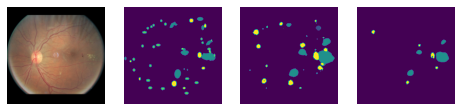

Plotting Activations


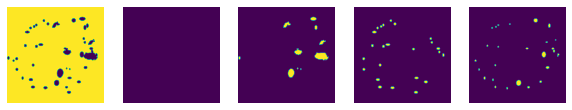

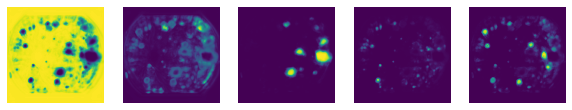

The loss on the first batch is : 0.6194654703140259
Loss at epoch : 9 : 0.489
Running Validation Step


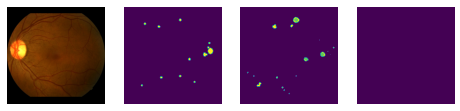

The loss on the first batch for validation is : 0.36739635467529297
Validation Loss at epoch : 9 : 0.41
Epoch : 9 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 10 -------------------------------------------------------------------


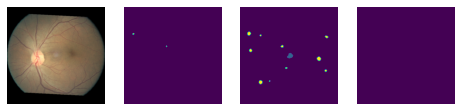

Plotting Activations


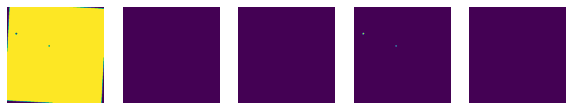

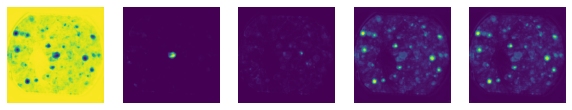

The loss on the first batch is : 0.21867400407791138
Loss at epoch : 10 : 0.467
Running Validation Step


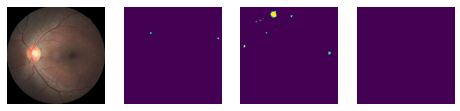

The loss on the first batch for validation is : 0.27978944778442383
Validation Loss at epoch : 10 : 0.42
Epoch : 10 took 1 mins : 55 seconds


------------------------------------------------------------------------------------------






Starting epoch : 11 -------------------------------------------------------------------


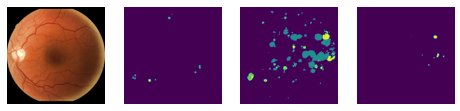

Plotting Activations


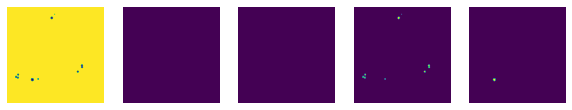

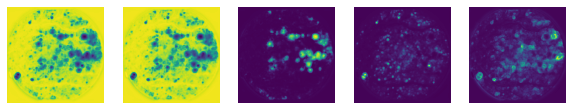

The loss on the first batch is : 0.4209181070327759
Loss at epoch : 11 : 0.445
Running Validation Step


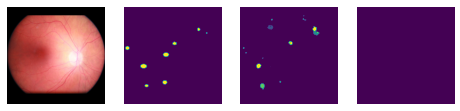

The loss on the first batch for validation is : 0.3188672363758087
Validation Loss at epoch : 11 : 0.388
Epoch : 11 took 1 mins : 55 seconds


------------------------------------------------------------------------------------------






Starting epoch : 12 -------------------------------------------------------------------


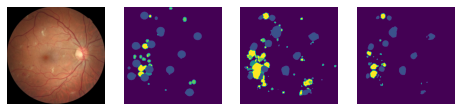

Plotting Activations


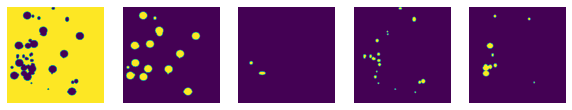

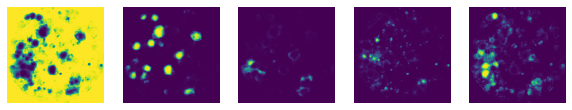

The loss on the first batch is : 0.8870938420295715
Loss at epoch : 12 : 0.429
Running Validation Step


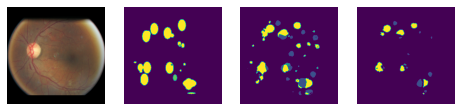

The loss on the first batch for validation is : 0.5640590190887451
Validation Loss at epoch : 12 : 0.392
Epoch : 12 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 13 -------------------------------------------------------------------


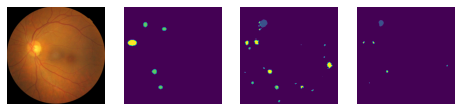

Plotting Activations


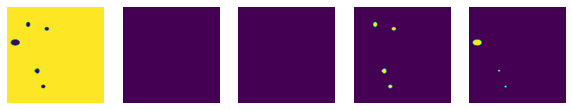

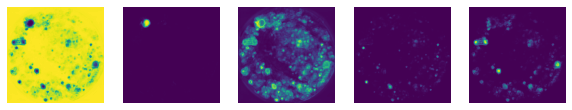

The loss on the first batch is : 0.24458739161491394
Loss at epoch : 13 : 0.423
Running Validation Step


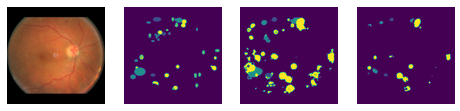

The loss on the first batch for validation is : 0.48377618193626404
Validation Loss at epoch : 13 : 0.383
Epoch : 13 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 14 -------------------------------------------------------------------


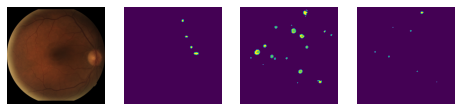

Plotting Activations


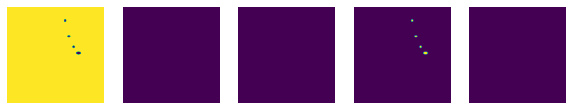

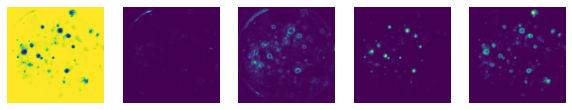

The loss on the first batch is : 0.4653196334838867
Loss at epoch : 14 : 0.424
Running Validation Step


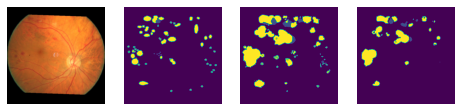

The loss on the first batch for validation is : 0.24706219136714935
Validation Loss at epoch : 14 : 0.394
Epoch : 14 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 15 -------------------------------------------------------------------


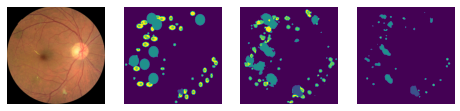

Plotting Activations


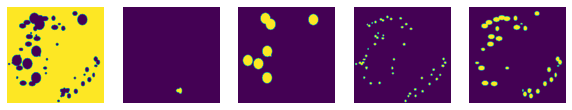

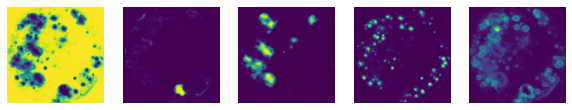

The loss on the first batch is : 0.3997496962547302
Loss at epoch : 15 : 0.414
Running Validation Step


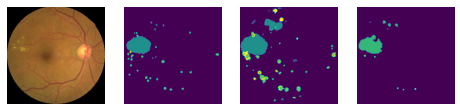

The loss on the first batch for validation is : 0.6368984580039978
Validation Loss at epoch : 15 : 0.413
Epoch : 15 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 16 -------------------------------------------------------------------


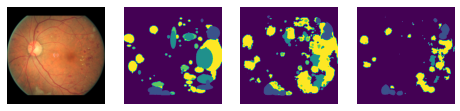

Plotting Activations


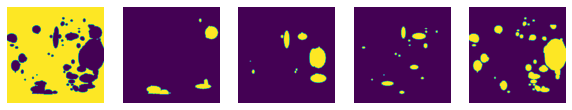

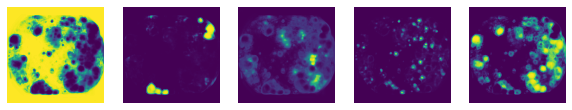

The loss on the first batch is : 0.6532714366912842
Loss at epoch : 16 : 0.414
Running Validation Step


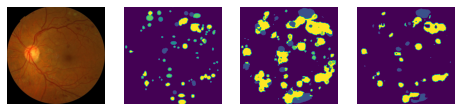

The loss on the first batch for validation is : 0.5223836302757263
Validation Loss at epoch : 16 : 0.396
Epoch : 16 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 17 -------------------------------------------------------------------


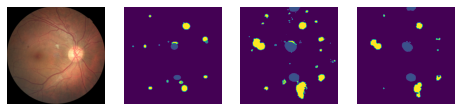

Plotting Activations


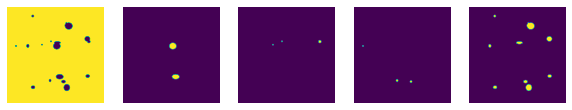

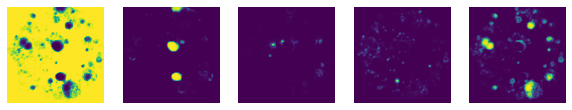

The loss on the first batch is : 0.36739033460617065
Loss at epoch : 17 : 0.41
Running Validation Step


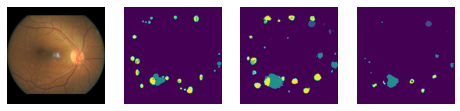

The loss on the first batch for validation is : 0.40808600187301636
Validation Loss at epoch : 17 : 0.419
Epoch : 17 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 18 -------------------------------------------------------------------


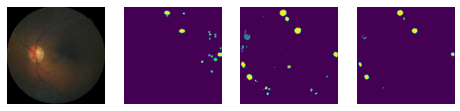

Plotting Activations


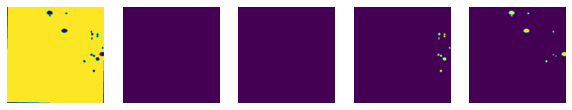

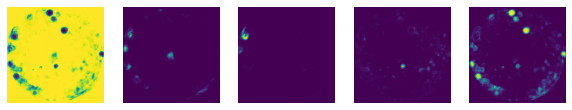

The loss on the first batch is : 0.211124986410141
Loss at epoch : 18 : 0.391
Running Validation Step


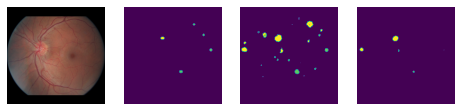

The loss on the first batch for validation is : 0.6186626553535461
Validation Loss at epoch : 18 : 0.409
Epoch : 18 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 19 -------------------------------------------------------------------


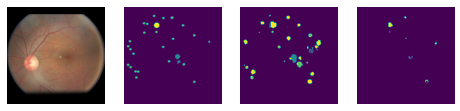

Plotting Activations


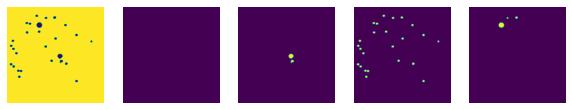

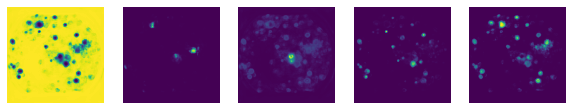

The loss on the first batch is : 0.5400871634483337
Loss at epoch : 19 : 0.38
Running Validation Step


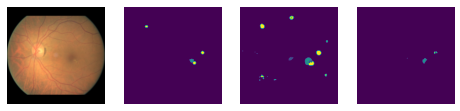

The loss on the first batch for validation is : 0.16108371317386627
Validation Loss at epoch : 19 : 0.407
Epoch : 19 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 20 -------------------------------------------------------------------


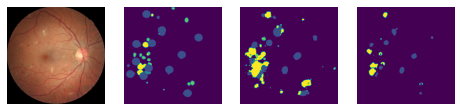

Plotting Activations


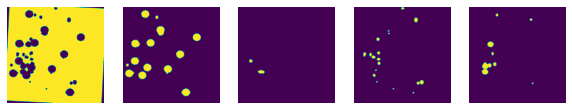

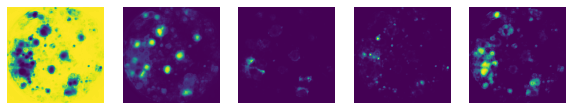

The loss on the first batch is : 0.550291895866394
Loss at epoch : 20 : 0.377
Running Validation Step


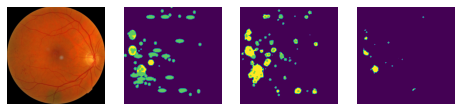

The loss on the first batch for validation is : 0.4181064963340759
Validation Loss at epoch : 20 : 0.407
Epoch : 20 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 21 -------------------------------------------------------------------


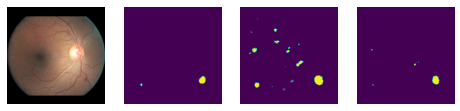

Plotting Activations


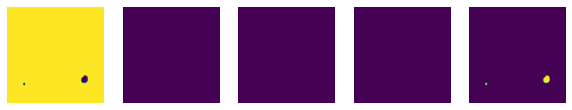

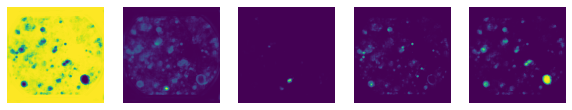

The loss on the first batch is : 0.7178795337677002
Loss at epoch : 21 : 0.363
Running Validation Step


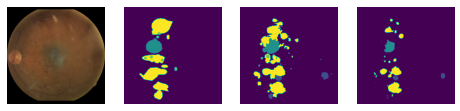

The loss on the first batch for validation is : 0.43527546525001526
Validation Loss at epoch : 21 : 0.4
Epoch : 21 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 22 -------------------------------------------------------------------


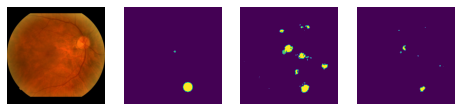

Plotting Activations


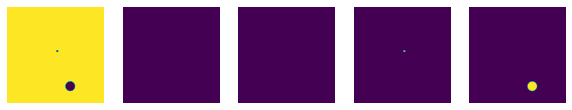

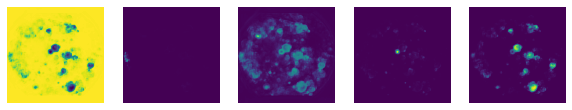

The loss on the first batch is : 0.240240678191185
Loss at epoch : 22 : 0.379
Running Validation Step


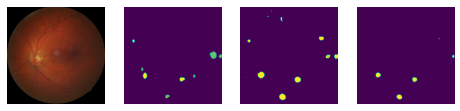

The loss on the first batch for validation is : 0.5146980285644531
Validation Loss at epoch : 22 : 0.425
Epoch : 22 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 23 -------------------------------------------------------------------


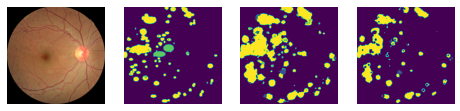

Plotting Activations


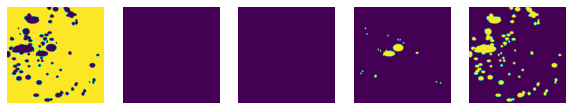

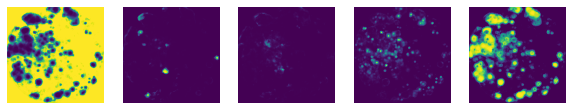

The loss on the first batch is : 0.2926168143749237
Loss at epoch : 23 : 0.351
Running Validation Step


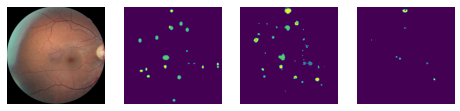

The loss on the first batch for validation is : 0.36637020111083984
Validation Loss at epoch : 23 : 0.433
Epoch : 23 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 24 -------------------------------------------------------------------


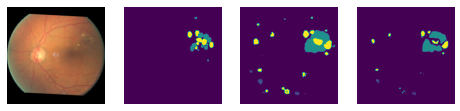

Plotting Activations


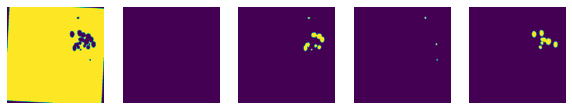

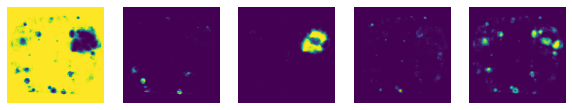

The loss on the first batch is : 0.4163703918457031
Loss at epoch : 24 : 0.365
Running Validation Step


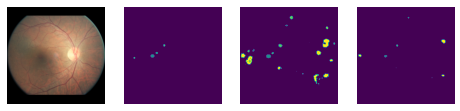

The loss on the first batch for validation is : 0.32146400213241577
Validation Loss at epoch : 24 : 0.412
Epoch : 24 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 25 -------------------------------------------------------------------


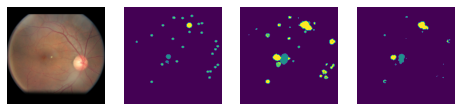

Plotting Activations


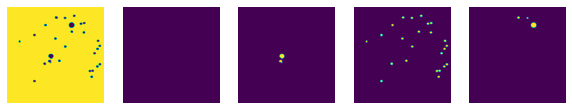

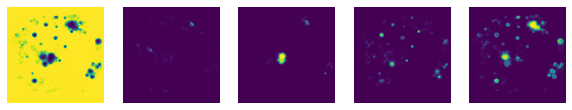

The loss on the first batch is : 0.17724402248859406
Loss at epoch : 25 : 0.363
Running Validation Step


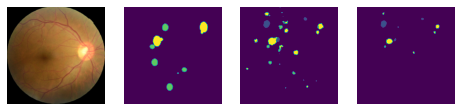

The loss on the first batch for validation is : 0.27982571721076965
Validation Loss at epoch : 25 : 0.434
Epoch : 25 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 26 -------------------------------------------------------------------


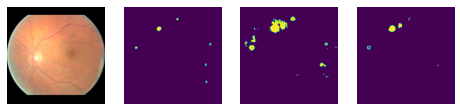

Plotting Activations


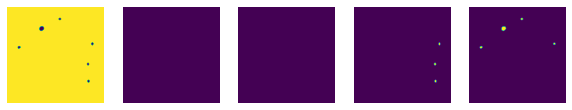

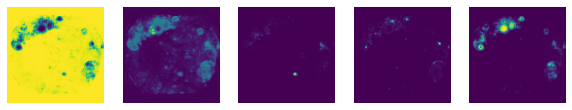

The loss on the first batch is : 0.329722136259079
Loss at epoch : 26 : 0.366
Running Validation Step


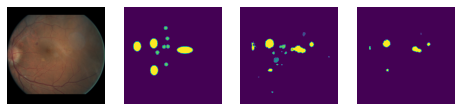

The loss on the first batch for validation is : 0.26304516196250916
Validation Loss at epoch : 26 : 0.417
Epoch : 26 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 27 -------------------------------------------------------------------


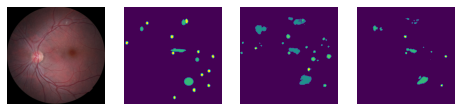

Plotting Activations


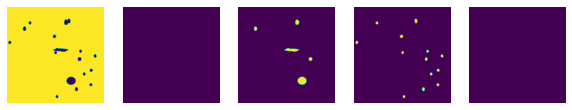

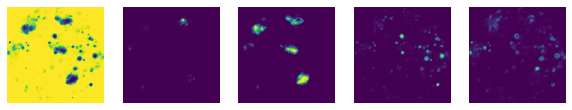

The loss on the first batch is : 0.2230992168188095
Loss at epoch : 27 : 0.348
Running Validation Step


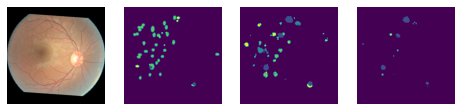

The loss on the first batch for validation is : 0.350593239068985
Validation Loss at epoch : 27 : 0.441
Epoch : 27 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 28 -------------------------------------------------------------------


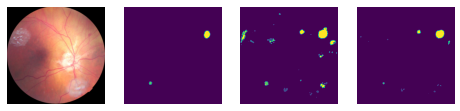

Plotting Activations


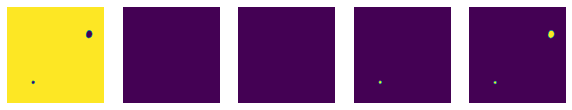

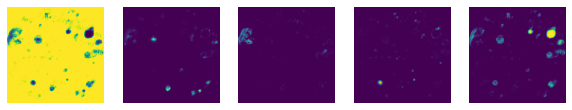

The loss on the first batch is : 0.42548611760139465
Loss at epoch : 28 : 0.353
Running Validation Step


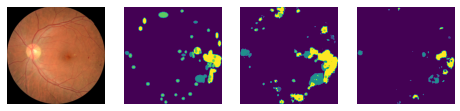

The loss on the first batch for validation is : 0.7832973003387451
Validation Loss at epoch : 28 : 0.412
Epoch : 28 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 29 -------------------------------------------------------------------


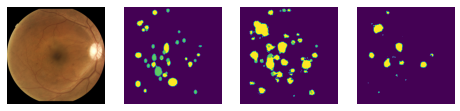

Plotting Activations


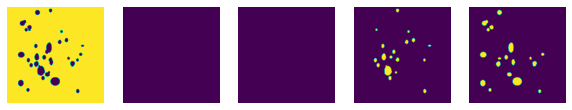

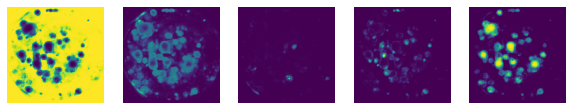

The loss on the first batch is : 0.7214770913124084
Loss at epoch : 29 : 0.348
Running Validation Step


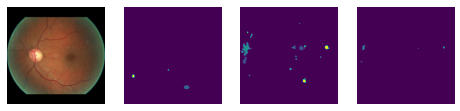

The loss on the first batch for validation is : 0.27153635025024414
Validation Loss at epoch : 29 : 0.439
Epoch : 29 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 30 -------------------------------------------------------------------


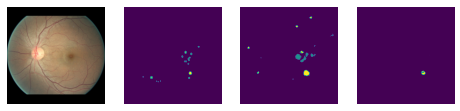

Plotting Activations


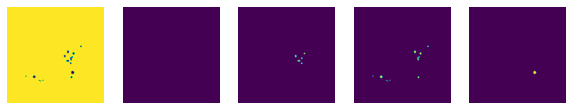

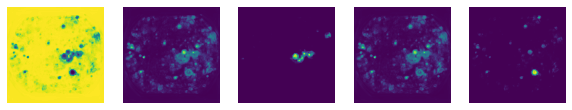

The loss on the first batch is : 0.4228569567203522
Loss at epoch : 30 : 0.348
Running Validation Step


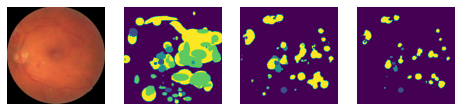

The loss on the first batch for validation is : 1.615909457206726
Validation Loss at epoch : 30 : 0.429
Epoch : 30 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 31 -------------------------------------------------------------------


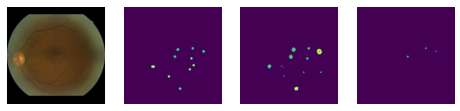

Plotting Activations


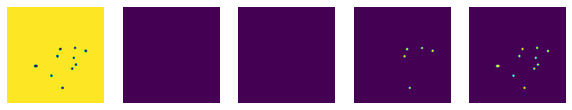

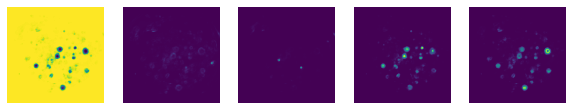

The loss on the first batch is : 0.3989349901676178
Loss at epoch : 31 : 0.358
Running Validation Step


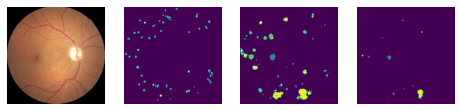

The loss on the first batch for validation is : 1.5136892795562744
Validation Loss at epoch : 31 : 0.434
Epoch : 31 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 32 -------------------------------------------------------------------


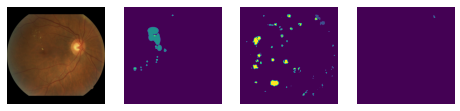

Plotting Activations


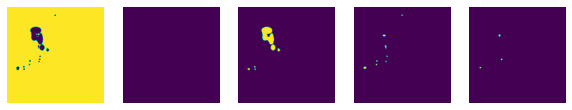

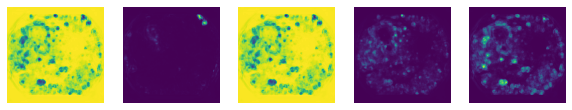

The loss on the first batch is : 0.38321277499198914
Loss at epoch : 32 : 0.358
Running Validation Step


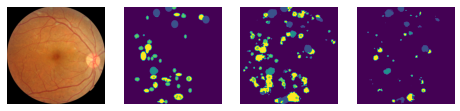

The loss on the first batch for validation is : 0.6022356152534485
Validation Loss at epoch : 32 : 0.414
Epoch : 32 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 33 -------------------------------------------------------------------


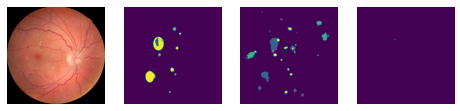

Plotting Activations


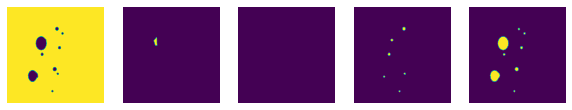

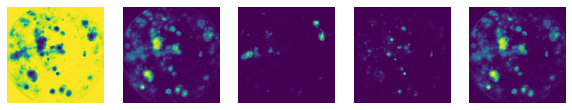

The loss on the first batch is : 0.4505782425403595
Loss at epoch : 33 : 0.365
Running Validation Step


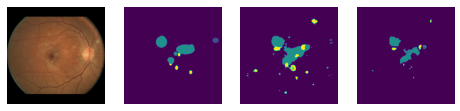

The loss on the first batch for validation is : 0.2097618281841278
Validation Loss at epoch : 33 : 0.428
Epoch : 33 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 34 -------------------------------------------------------------------


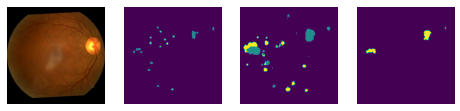

Plotting Activations


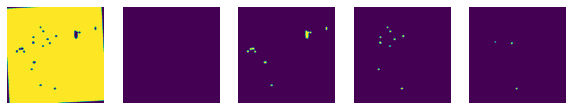

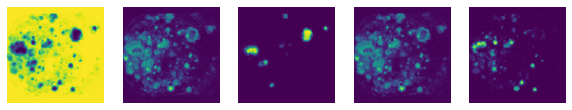

The loss on the first batch is : 0.2439878135919571
Loss at epoch : 34 : 0.362
Running Validation Step


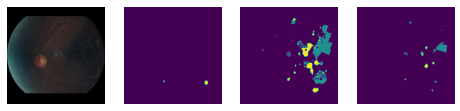

The loss on the first batch for validation is : 0.36004096269607544
Validation Loss at epoch : 34 : 0.457
Epoch : 34 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 35 -------------------------------------------------------------------


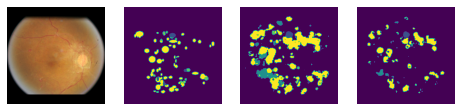

Plotting Activations


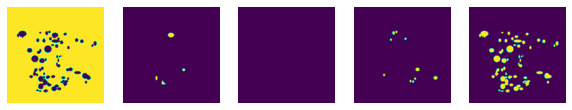

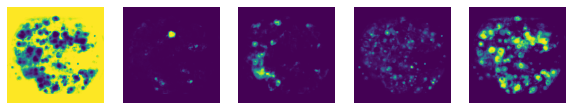

The loss on the first batch is : 0.47964343428611755
Loss at epoch : 35 : 0.355
Running Validation Step


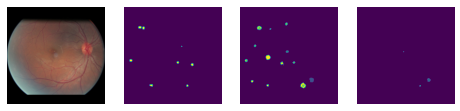

The loss on the first batch for validation is : 0.8505520820617676
Validation Loss at epoch : 35 : 0.435
Epoch : 35 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 36 -------------------------------------------------------------------


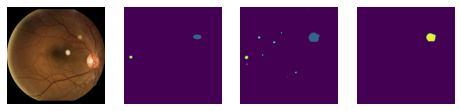

Plotting Activations


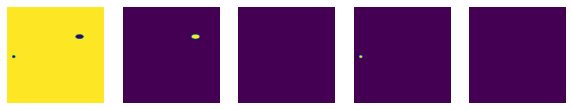

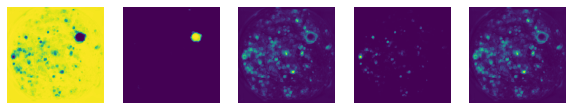

The loss on the first batch is : 0.42703744769096375
Loss at epoch : 36 : 0.345
Running Validation Step


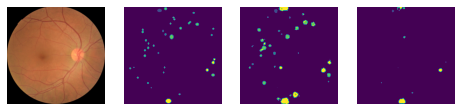

The loss on the first batch for validation is : 0.5621600151062012
Validation Loss at epoch : 36 : 0.415
Epoch : 36 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 37 -------------------------------------------------------------------


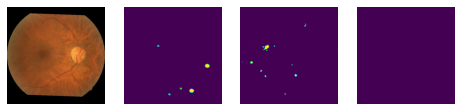

Plotting Activations


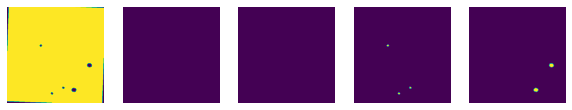

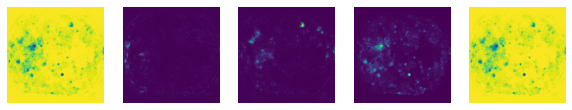

The loss on the first batch is : 0.3427028954029083
Loss at epoch : 37 : 0.354
Running Validation Step


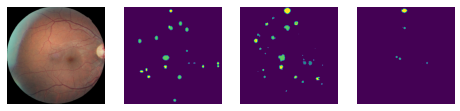

The loss on the first batch for validation is : 0.24282856285572052
Validation Loss at epoch : 37 : 0.424
Epoch : 37 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 38 -------------------------------------------------------------------


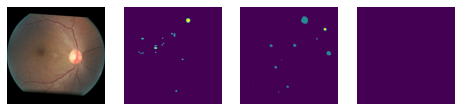

Plotting Activations


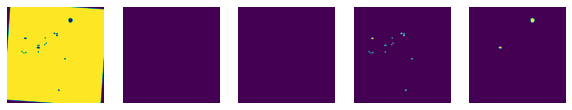

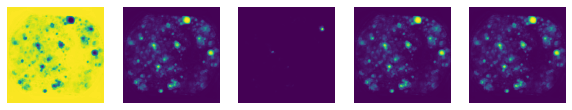

The loss on the first batch is : 0.15851011872291565
Loss at epoch : 38 : 0.35
Running Validation Step


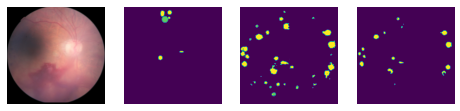

The loss on the first batch for validation is : 0.440633088350296
Validation Loss at epoch : 38 : 0.43
Epoch : 38 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 39 -------------------------------------------------------------------


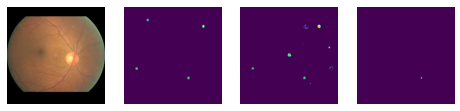

Plotting Activations


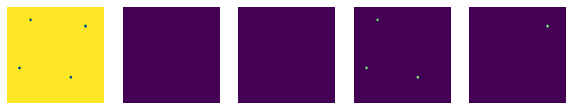

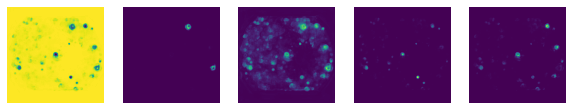

The loss on the first batch is : 0.4947434961795807
Loss at epoch : 39 : 0.347
Running Validation Step


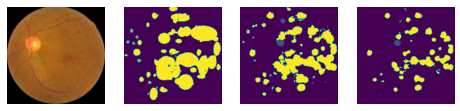

The loss on the first batch for validation is : 0.5845447182655334
Validation Loss at epoch : 39 : 0.437
Epoch : 39 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 40 -------------------------------------------------------------------


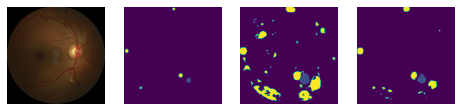

Plotting Activations


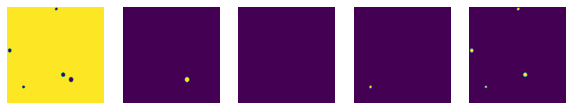

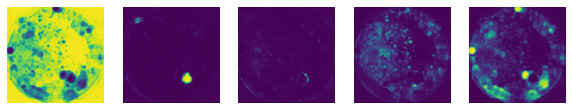

The loss on the first batch is : 0.27992698550224304
Loss at epoch : 40 : 0.342
Running Validation Step


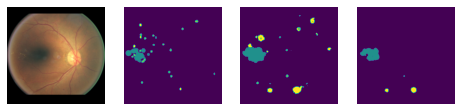

The loss on the first batch for validation is : 0.13640230894088745
Validation Loss at epoch : 40 : 0.435
Epoch : 40 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 41 -------------------------------------------------------------------


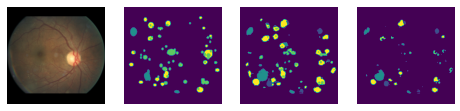

Plotting Activations


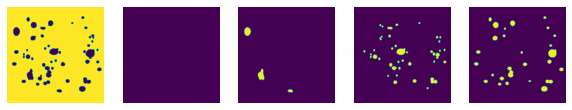

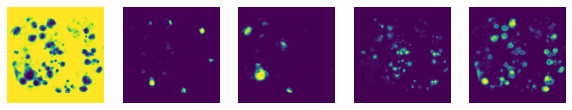

The loss on the first batch is : 0.4875015914440155
Loss at epoch : 41 : 0.338
Running Validation Step


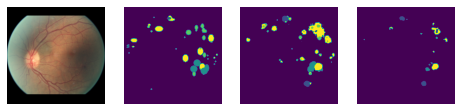

The loss on the first batch for validation is : 0.8518643379211426
Validation Loss at epoch : 41 : 0.419
Epoch : 41 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 42 -------------------------------------------------------------------


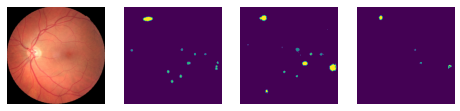

Plotting Activations


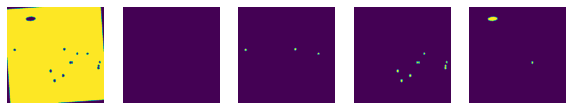

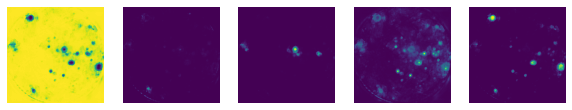

The loss on the first batch is : 0.36017853021621704
Loss at epoch : 42 : 0.355
Running Validation Step


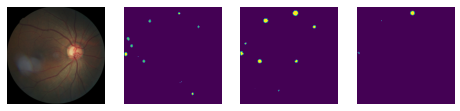

The loss on the first batch for validation is : 0.24447141587734222
Validation Loss at epoch : 42 : 0.411
Epoch : 42 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 43 -------------------------------------------------------------------


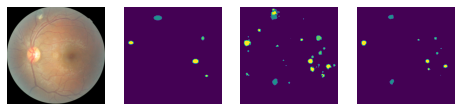

Plotting Activations


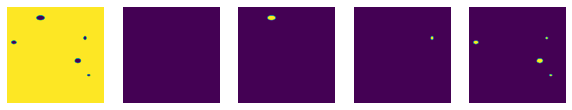

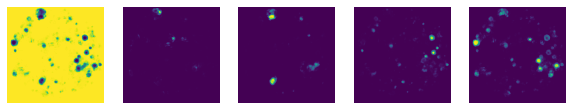

The loss on the first batch is : 0.28395575284957886
Loss at epoch : 43 : 0.358
Running Validation Step


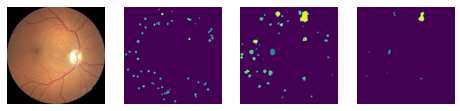

The loss on the first batch for validation is : 0.3590865433216095
Validation Loss at epoch : 43 : 0.416
Epoch : 43 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 44 -------------------------------------------------------------------


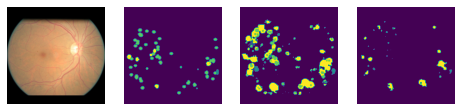

Plotting Activations


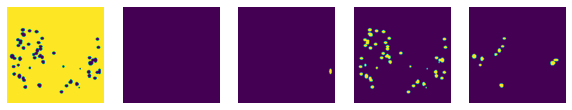

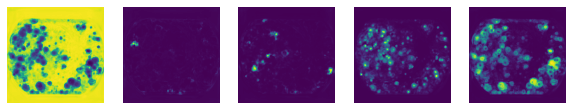

The loss on the first batch is : 0.328086793422699
Loss at epoch : 44 : 0.359
Running Validation Step


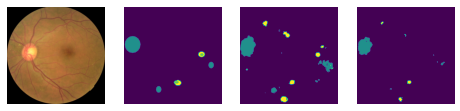

The loss on the first batch for validation is : 0.27904850244522095
Validation Loss at epoch : 44 : 0.436
Epoch : 44 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 45 -------------------------------------------------------------------


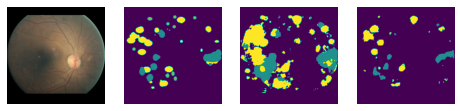

Plotting Activations


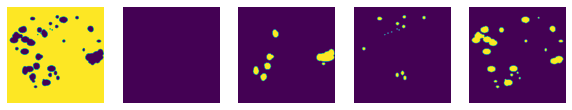

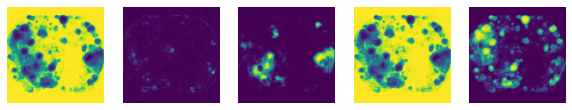

The loss on the first batch is : 0.5411028861999512
Loss at epoch : 45 : 0.343
Running Validation Step


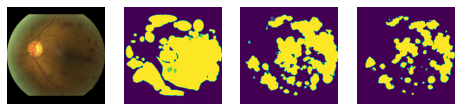

The loss on the first batch for validation is : 0.8455503582954407
Validation Loss at epoch : 45 : 0.417
Epoch : 45 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 46 -------------------------------------------------------------------


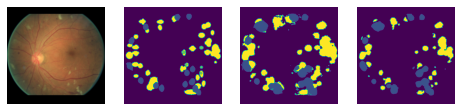

Plotting Activations


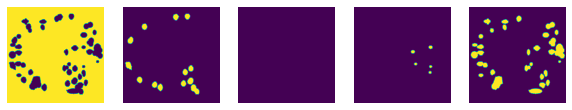

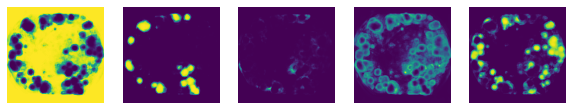

The loss on the first batch is : 0.2854962944984436
Loss at epoch : 46 : 0.34
Running Validation Step


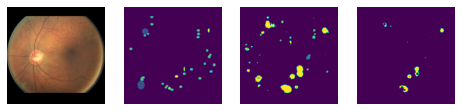

The loss on the first batch for validation is : 0.47072312235832214
Validation Loss at epoch : 46 : 0.428
Epoch : 46 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 47 -------------------------------------------------------------------


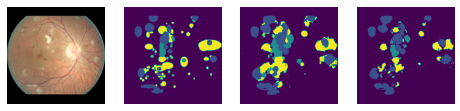

Plotting Activations


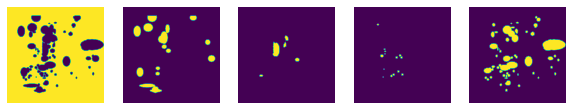

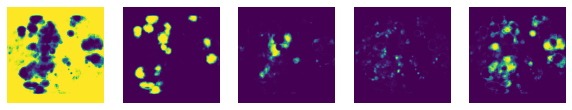

The loss on the first batch is : 0.28249967098236084
Loss at epoch : 47 : 0.344
Running Validation Step


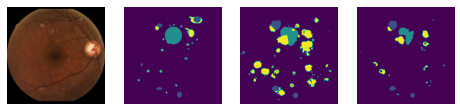

The loss on the first batch for validation is : 0.42166540026664734
Validation Loss at epoch : 47 : 0.421
Epoch : 47 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 48 -------------------------------------------------------------------


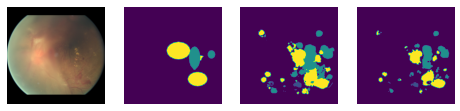

Plotting Activations


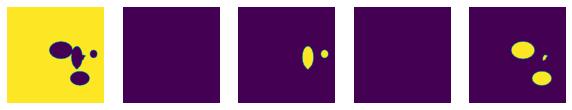

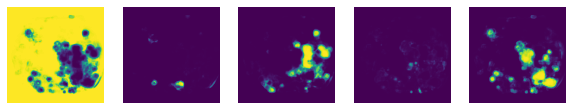

The loss on the first batch is : 0.45348626375198364
Loss at epoch : 48 : 0.349
Running Validation Step


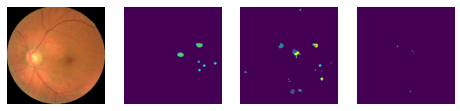

The loss on the first batch for validation is : 0.5044453740119934
Validation Loss at epoch : 48 : 0.421
Epoch : 48 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 49 -------------------------------------------------------------------


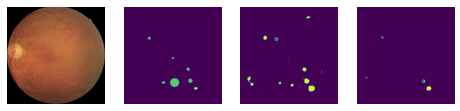

Plotting Activations


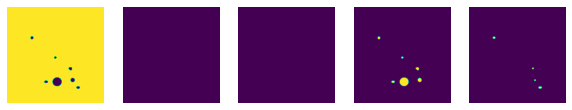

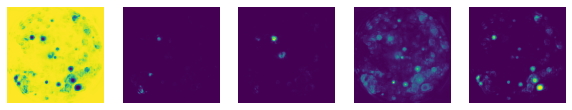

The loss on the first batch is : 0.25621017813682556
Loss at epoch : 49 : 0.356
Running Validation Step


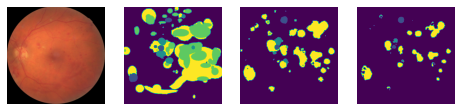

The loss on the first batch for validation is : 1.61692476272583
Validation Loss at epoch : 49 : 0.431
Epoch : 49 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------






Starting epoch : 50 -------------------------------------------------------------------


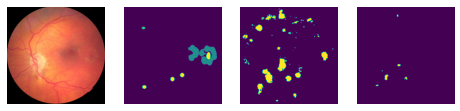

Plotting Activations


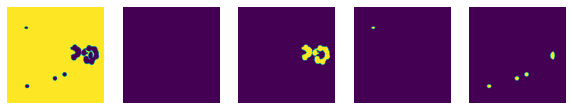

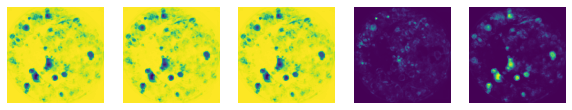

The loss on the first batch is : 0.5558727979660034
Loss at epoch : 50 : 0.343
Running Validation Step


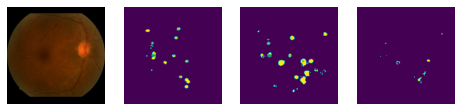

The loss on the first batch for validation is : 0.3339640498161316
Validation Loss at epoch : 50 : 0.421
Epoch : 50 took 1 mins : 54 seconds


------------------------------------------------------------------------------------------








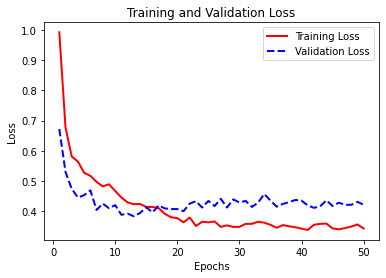

In [35]:
trainer.fit(log=True, validation=True, valid_dl=valid_dl, model_save_path="./model_weights/stage_1/vgg_simple.pth")

In [ ]:
"model_weights/stage_1/simple_unet.pth"

In [40]:
torch.save(vgg_unet.state_dict(), "./model_weights/stage_1/complex_vgg_end.pth")

NameError: name 'unet' is not defined

# Evaluation

This stage will carry out evaluation of various stages.

### Evaluation Pipeline

In [29]:
import json
class EvalPipeline:
    
    def __init__(self, dataloader, n,model_dict, class_dict, color_dict):
        
        """"This is an evaluation pipeline which can be used to determine the evaluation metrics for a group of segmentation models."""

        self.dl = dataloader
        self.img, self.gt = zip(*[(data[0].numpy(), data[1].numpy()) for data in dataloader])
        self.img = np.concatenate(self.img)
        #For the methods defined below, the ground-truths need to be in the following shape : (B, H, W, 1)
        self.gt = np.concatenate(self.gt)
        self.gt = np.transpose(self.gt, (0, 2, 3, 1))
        self.gt = np.argmax(self.gt, axis=3)
        self.gt = np.expand_dims(self.gt, axis=-1)
        
        self.model_dict = model_dict
        self.n = n
        self.class_dict = class_dict
        self.color_dict = color_dict
        self.prediction_gen()
        
    def prediction_gen(self):

        """Generates predictions for each segmentation model"""
        
        predictions = {}
        
        for m in self.model_dict.keys():
            model = self.model_dict[m]

            #For the methods below, the predictions need to be in the following shape : (B, H, W, 1)
            pred = model.predict(self.dl)
            pred = np.argmax(pred, axis=-1)
            pred = np.expand_dims(pred, axis=-1)
            
            predictions[m] = pred
            
        self.pred = predictions
    
    #This function swaps colors from a class map
    def color_swap(self, img):
    
        for key in self.color_dict.keys():

            c = np.where(img[:, :, [0,1,2]] == [key, key, key])
            img[c[0], c[1], :] = self.color_dict[key]

        return img
    
    def image_overlay(self, img, ann):
        
        """This function overlays the annotation over the image
        This function assumes that the background color is pixel value (0,0,0) in RGB
        img : numpy array in the shape : (height, width, color, alpha)
        ann : numpy array in the shape : (height, width, color, alpha)"""
        
        c = np.where(ann[:,:,[0,1,2]] == [0,0,0])
        c_2 = np.where(ann[:,:,[0,1,2]] != [0,0,0])
        ann[c[0], c[1],-1] = 0
        ann[c_2[0], c_2[1],-1] = 100
        
        img = Image.fromarray(img)
        ann = Image.fromarray(ann)
        
        #Overlaying the annotation on the image
        img.paste(ann, (0,0), ann)
        img = np.array(img)
        
        return img
            
    
    def stage_one(self, metrics=["SENS", "SPEC", "IoU", "DSC"], path="stage_1.csv"):
        
        scores = {}
        
        #First evaluate the same metric for all sets of predictions
        print(metrics)
        for metric in metrics:
            
            scores[metric] = []
            for p in self.pred.keys():
                
                
                current_pred = self.pred[p]
                #Evaluate for the current prediction
                score = evaluate(self.gt, current_pred, metric=metric, multi_class=True, n_classes=self.n)
                score = np.mean(score)
                scores[metric].append(score)
                
        with open(path, "w") as f:
            for m in metrics:
                f.write(m)
                f.write(",")
            f.write("\n") 
            for i in range(len(scores[m])):
                for m in metrics:
                
                    f.write(str(scores[m][i]))
                    f.write(",")
                f.write("\n")
            
            
        return scores
    
    def stage_two(self, metrics=["SENS", "SPEC", "IoU", "DSC"], path="stage_2.json"):
        
        scores = {}
        
        # Have to change all of done_pred instances into self.pred
        for p in self.pred.keys():
            scores[p] = []
            print(f"Working on : {p}...")
            for metric in metrics:
                
                current_pred = self.pred[p]
                #Evaluate for the current prediction
                score = evaluate(self.gt, current_pred, metric=metric, multi_class=True, n_classes=self.n)
                scores[p].append(score)
            
            scores[p] = np.array(scores[p]).T
        
        scores_2 = {}
        
        print("Creating final dict")
        for p in self.pred.keys():
            scores_2[p] = {}
            for i, c in enumerate(self.class_dict):
                scores_2[p][c] = {}
                for n, m in enumerate(metrics):
                    scores_2[p][c][m] = scores[p][i][n]
        
        

        with open(path, "w") as json_file:
            json.dump(scores_2, json_file)
        
        
        return scores_2
    
    def stage_three(self, img_dir, gt_dir, img_files, gt_files, path="stage_3.png"):
        
        assert len(img_files) == len(gt_files)
        n_cols = len(img_files)
        n_rows = len(list(self.model_dict.keys())) + 1
        
        #Defining the figure
        fig, ax = plt.subplots(n_cols, n_rows, figsize=(n_rows*3,n_cols*3))
        
        #Plotting the ground truth overlayed on the image
        for i, (img, ann) in enumerate(zip(img_files, gt_files)):
            
            
            
            img_path = os.path.join(img_dir, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA)
            
            gt_path = os.path.join(gt_dir, ann)
            gt = cv2.imread(gt_path)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGBA)
            
            overlay_img = self.image_overlay(image, gt)
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_RGBA2RGB)
            ax[i, 0].imshow(overlay_img)
            ax[i, 0].set_xlabel("ground truth")
            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
        
        for i, model_name in enumerate(self.model_dict.keys()):
            
            i = i+1
            model = self.model_dict[model_name]
            
            for n, img in enumerate(img_files):
                
                img_path = os.path.join(img_dir, img)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (512, 512))
                image = image / 255.0
                image = np.transpose(image, (2, 0, 1))
                image = torch.from_numpy(image).float()
                
                pred = model.predict_image(image)
                pred = np.argmax(pred, axis=-1)
                pred = np.transpose(pred, (1,2,0))
                pred = np.repeat(pred, repeats=3,axis=-1)
                pred = self.color_swap(pred)
                pred = np.uint8(pred)
                pred = cv2.cvtColor(pred, cv2.COLOR_RGB2RGBA)

                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGBA) 
                image = cv2.resize(image, (512, 512))
                
                overlayed_prediction = self.image_overlay(image, pred)
                overlayed_prediction = cv2.cvtColor(overlayed_prediction, cv2.COLOR_RGBA2RGB)
                
                ax[n, i].imshow(overlayed_prediction)
                ax[n, i].set_xticks([])
                ax[n, i].set_yticks([])
                ax[n, i].set_xlabel(model_name)
                
                
            
            
            
        
        

    
    def stage_four(self, img_dir, gt_dir, img_files, gt_files, path="stage_4.png"):
        
        """This method is used to compare the predictions of the models passed in with the ground truth for all the images passed in as arguments into this function.
        img_dir : this is the directory of the images : string
        gt_dir : this is the directory where the ground truth images are present : string
        img_files : the specific image file names choosen to plot : list of strings
        gt_files : the corresponding ground truth files choosen to comapare against : list of strings
        The img_files and gt_files must be present within the img_dir and gt_dir respectively.
        Furthermore, the same number of image files and ground truth files should be passed in.
        """
        
        #Number of images should be the same as G.T
        assert len(img_files) == len(gt_files)
        print(img_dir)
        print(gt_dir)
        print(img_files)
        print(gt_files)
        
        n_cols = len(img_files)
        n_rows = len(list(self.model_dict.keys())) +2
        
        #Defining the figure
        fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3,n_rows*3))
        
        ax[0, 0].set_ylabel("images")
        ax[1, 0].set_ylabel("ground_truth")
        
        #Plotting the images first
        for i, img in enumerate(img_files):
            
            img_path = os.path.join(img_dir, img)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax[0, i].imshow(image)
            
            ax[0,i].set_xticks([])
            ax[0, i].set_yticks([])
        
        #Plotting the ground truth
        for i, ann in enumerate(gt_files):
            
            gt_path = os.path.join(gt_dir, ann)
            gt = cv2.imread(gt_path)
            gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB)
            #gt = cv2.resize(gt, (512, 512))

            ax[1, i].imshow(gt)
            
            ax[1,i].set_xticks([])
            ax[1, i].set_yticks([])
        
        for i, model_name in enumerate(self.model_dict.keys()):
            
            i = i+2
            model = self.model_dict[model_name]
            ax[i, 0].set_ylabel(model_name)
            
            for n, img in enumerate(img_files):
                
                img_path = os.path.join(img_dir, img)
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, (512, 512))
                image = image / 255.0
                image = np.transpose(image, (2, 0, 1))
                image = torch.from_numpy(image).float()
                
                pred = model.predict_image(image)
                pred = np.argmax(pred, axis=-1)
                pred = np.transpose(pred, (1,2,0))
                pred = np.repeat(pred, repeats=3,axis=-1)
                pred = self.color_swap(pred)
                
                ax[i, n].imshow(pred)
                ax[i,n].set_xticks([])
                ax[i,n].set_yticks([])
            
        plt.subplots_adjust(left=0.2,
                    right=0.9,
                    wspace=0.4,
                    hspace=0.4)
            
        plt.savefig(path, dpi=100)
        
    
    ### Stage 5 : F1 score plots per model per class
    
    def stage_five(self, path="stage_5.png"):
        

        
        markers = ["x", "+", ".", "1", "*", "d"]
        colors = ["lime", "fuchsia", "darkorange", "gold", "salmon", "indigo"]
        
        model_names = list(self.pred.keys())
        
        fig, ax = plt.subplots(1,1, figsize=(6,self.n))
        ys = range(self.n)
        
        for i, model_name in enumerate(model_names):
            
            pred = self.pred[model_name]
            
            prec = evaluate(self.gt, pred, metric="PREC", multi_class=True, n_classes=self.n)
            recall = evaluate(self.gt, pred, metric="Recall", multi_class=True, n_classes=self.n)
            
            f1 = (2 * prec * recall) / (prec + recall)
            
            some_num = np.random.uniform(0.1, 0.3, 1)
            
            ax.scatter(x=f1, y=ys, color=colors[i], marker=markers[i], label=model_name)
            ax.set_yticks(ticks=list(range(5)),labels=self.class_dict)
            ax.legend(loc="best")
            ax.grid()
        
        plt.savefig(path, dpi=100)
        
        
        
    

## Stage 0 - Tests

This stage just tests the functioning of the evaluation pipeline

#### Testing

In [109]:
simple_vgg = VGGUNet(5, simple=True).to(device)

In [25]:
simple_vgg_state_dict = torch.load("./model_weights/stage_1/vgg_simple.pth", map_location=device)

In [110]:
simple_vgg.load_state_dict(simple_vgg_state_dict)

<All keys matched successfully>

In [82]:
test_predictions = simple_vgg.predict(test_dl)

100%|██████████| 40/40 [00:06<00:00,  6.44it/s]


In [261]:
test_predictions_a = np.argmax(test_predictions, axis=-1)
test_predictions_a = np.expand_dims(test_predictions_a, axis=-1)

In [262]:
test_predictions_a.shape

(158, 512, 512, 1)

In [244]:
test_img_file = test_img[1]
print(test_img_file)

./fundus_images/5652_left.jpg


In [245]:
test_im = cv2.imread(test_img_file)
test_im = cv2.resize(test_im, (512, 512))
test_im = test_im / 255.0
test_im = np.transpose(test_im, (2, 0, 1))
test_im = torch.from_numpy(test_im).float()

test_prediction = simple_vgg.predict_image(test_im)

In [246]:
test_gt = np.argmax(test_prediction, axis=-1)
test_gt = np.transpose(test_gt, (1, 2, 0))


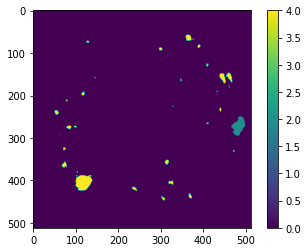

In [247]:
plt.imshow(test_gt)
plt.colorbar()

In [248]:
print(test_gt.shape)
np.unique(test_gt)

(512, 512, 1)


array([0, 1, 2, 3, 4])

In [249]:
test_gt = np.repeat(test_gt, repeats=3,axis=-1)

In [250]:
test_gt.shape

(512, 512, 3)

In [251]:
np.unique(test_gt)
#1 cotton wool spots
#2 hard_exudates
#3 microaneurysm
#4 retinal haemorrhage



array([0, 1, 2, 3, 4])

In [234]:
c = np.where(test_gt[:,:, [0,1,2]] == [2, 2, 2])
test_gt[c[0], c[1], :] = np.array([[245, 234, 133]])

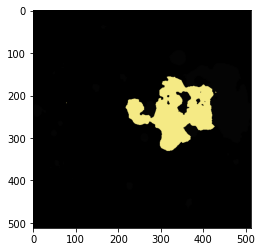

In [235]:
plt.imshow(test_gt)

In [236]:
np.unique(test_gt)

array([  0,   1,   3,   4, 133, 234, 245])

In [237]:
c = np.where(test_gt[:,:, [0,1,2]] == [4,4,4])
test_gt[c[0], c[1], :] = np.array([[133, 213, 245]])

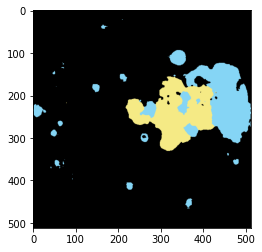

In [238]:
plt.imshow(test_gt)

In [239]:
c = np.where(test_gt[:, :, [0,1,2]] == [3, 3, 3])
test_gt[c[0], c[1], :] = np.array([[245, 128, 128]])

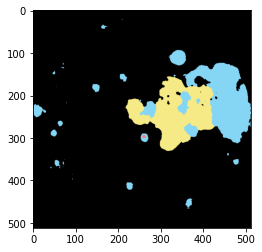

In [240]:
plt.imshow(test_gt)

In [242]:
c_dict =  {
    1 : np.array([[128, 242, 128]]),
    2 : np.array([[245, 234, 133]]),
    3 : np.array([[245, 128, 128]]),
    4 : np.array([[133, 213, 245]])
}

In [243]:
def color_swap(img, color_dict):
    
    for key in color_dict.keys():
        
        c = np.where(img[:, :, [0,1,2]] == [key, key, key])
        img[c[0], c[1], :] = color_dict[key]
    
    return img

In [252]:
test_gt = color_swap(test_gt, c_dict)

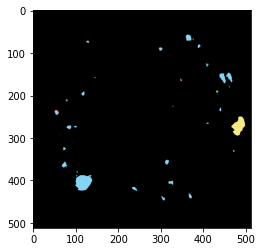

In [253]:
plt.imshow(test_gt)

#### Stage 1 Processing

In [37]:
simple_vgg = VGGUNet(5, simple=True).to(device)
complex_vgg = VGGUNet(5, simple=False).to(device)

In [38]:
simple_vgg_state_dict = torch.load("./model_weights/stage_1/vgg_simple.pth", map_location=device)
complex_vgg_state_dict = torch.load("./model_weights/stage_1/complex_vgg_best.pth", map_location=device)

simple_vgg.load_state_dict(simple_vgg_state_dict)
complex_vgg.load_state_dict(complex_vgg_state_dict)

<All keys matched successfully>

In [40]:
["background"] + classes

['background',
 'cotton_wool_spots',
 'hard_exudate',
 'microaneurysm',
 'retinal_hemorrhage']

In [142]:
c_dict =  {
    1 : np.array([[128, 242, 128]]),
    2 : np.array([[245, 234, 133]]),
    3 : np.array([[245, 128, 128]]),
    4 : np.array([[133, 213, 245]])
}
models_stage_1 = {
    "simple_vgg" : simple_vgg,
    "complex_vgg" : complex_vgg
}

evaluator = EvalPipeline(test_dl, 5, models_stage_1, ["background"] + classes, c_dict)

100%|██████████| 40/40 [00:12<00:00,  3.33it/s]


In [84]:
evaluator.gt.shape

(158, 512, 512, 1)

#### Error Diagnosis Break

In [74]:
test_eimg = evaluator.img[1]
test_eimg = np.transpose(test_eimg, (1,2,0))

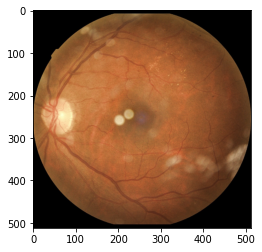

In [75]:
plt.imshow(test_eimg)

In [76]:
test_egt = evaluator.gt[1]
test_egt = np.squeeze(test_egt)

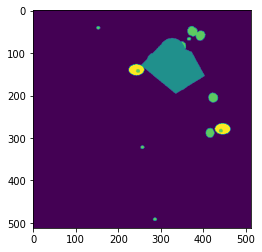

In [77]:
plt.imshow(test_egt)

In [78]:
preds_1 = evaluator.pred["simple_vgg"][1]
preds_1 = np.squeeze(preds_1)
preds_2 = evaluator.pred["complex_vgg"][1]
preds_2 = np.squeeze(preds_2)

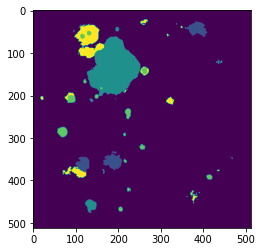

In [79]:
plt.imshow(preds_1)

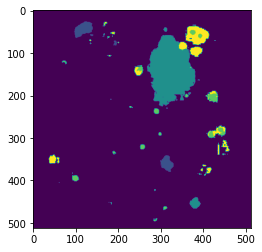

In [80]:
plt.imshow(preds_2)

#### Processing Continued

In [89]:
evaluator.stage_one(path="./experiment_results/stage_1/eval_stage_1.csv")

['SENS', 'SPEC', 'IoU', 'DSC']


{'SENS': [0.6095010349571208, 0.6246471409185574],
 'SPEC': [0.9274897255611411, 0.9294952774863106],
 'IoU': [0.3899786519541073, 0.386949272571875],
 'DSC': [0.5059734391122913, 0.5025449050252997]}

In [90]:
evaluator.stage_two(path="./experiment_results/stage_1/eval_stage_2.json")

Working on : simple_vgg...
Working on : complex_vgg...
Creating final dict


{'simple_vgg': {'background': {'SENS': 0.9691433287449751,
   'SPEC': 0.6719228586862899,
   'IoU': 0.9575845304405799,
   'DSC': 0.9783327519706779},
  'cotton_wool_spots': {'SENS': 0.5553718407616695,
   'SPEC': 0.9969914452799996,
   'IoU': 0.17030120012034633,
   'DSC': 0.2910382388787325},
  'hard_exudate': {'SENS': 0.708577735588849,
   'SPEC': 0.9917204602040746,
   'IoU': 0.4027227451908517,
   'DSC': 0.5742014900258255},
  'microaneurysm': {'SENS': 0.1859912384141163,
   'SPEC': 0.9983621882663858,
   'IoU': 0.15427302996670367,
   'DSC': 0.2673076923076923},
  'retinal_hemorrhage': {'SENS': 0.6284210312759938,
   'SPEC': 0.9784516753689547,
   'IoU': 0.2650117540520548,
   'DSC': 0.41898702237852825}},
 'complex_vgg': {'background': {'SENS': 0.9663571715187366,
   'SPEC': 0.6847625086575109,
   'IoU': 0.9552774970118607,
   'DSC': 0.977127285995729},
  'cotton_wool_spots': {'SENS': 0.6073005432708904,
   'SPEC': 0.9964052310098356,
   'IoU': 0.16406027585529867,
   'DSC': 0.2

In [108]:
img_dir = "./fundus_images/"
gt_dir = "./lesion_annotations_color/"

img_files = ["25867_left.jpg", "3868_left.jpg", "17840_right.jpg", "3637_right.jpg", "1008_right.jpg"]
gt_files = ["25867_left.png", "3868_left.png", "17840_right.png", "3637_right.png", "1008_right.png"]

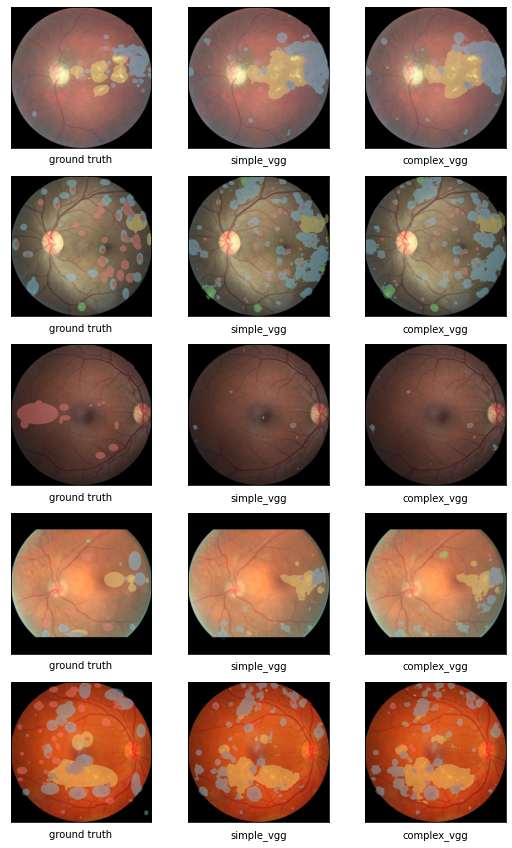

In [143]:
evaluator.stage_three(img_dir=img_dir, gt_dir=gt_dir, img_files=img_files, gt_files=gt_files, path="./experiment_results/stage_1/eval_stage_3.png")

./fundus_images/
./lesion_annotations_color/
['25867_left.jpg', '3868_left.jpg', '17840_right.jpg', '3637_right.jpg', '1008_right.jpg']
['25867_left.png', '3868_left.png', '17840_right.png', '3637_right.png', '1008_right.png']


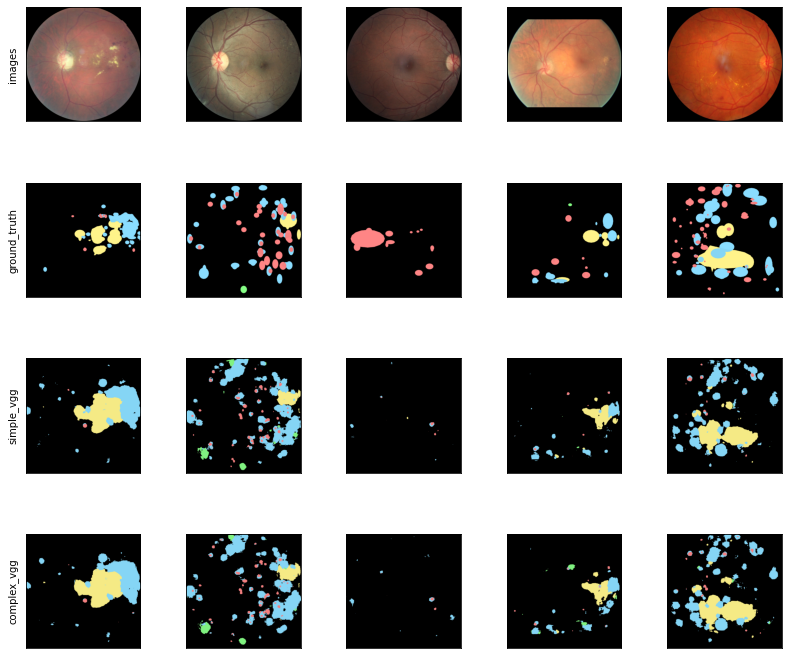

In [98]:
evaluator.stage_four(img_dir=img_dir, gt_dir=gt_dir, img_files=img_files, gt_files=gt_files, path="./experiment_results/stage_1/eval_stage_4.png")

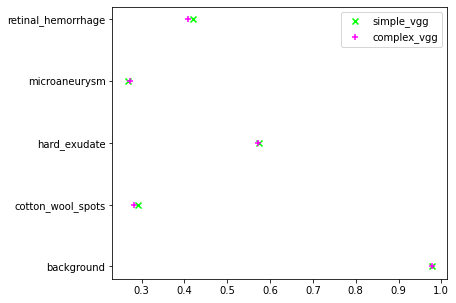

In [93]:
evaluator.stage_five(path="./experiment_results/stage_1/eval_stage_5.png")

## Stage 1

This stage will test whether to train the U-Net's encoder and decoder from scratch, or to use a pre-trained network as the encoder.

The experiments will consist of the following:

- Comparing a U-Net trained from scratch (using a simple decoder) with a U-Net using a VGG network as the pretrained encoder
- Comparing a U-Net trained from scratch (using a simple decoder) with a U-Net using a Resnet as the pretrained encoder
- Comparing a U-Net trained from scratch (using a simple decoder) with a U-Net using a Efficient-Net B4 as a pretrained encoder

<i>All the U-Nets that are being tested consist of the simple decoder</i>

In [30]:
os.listdir("./model_weights/stage_1/")

['simple_unet.pth',
 'complex_vgg_best.pth',
 'complex_effunet.pth',
 'vgg_simple.pth',
 'simple_effunet.pth',
 'complex_unet.pth',
 '.ipynb_checkpoints',
 'complex_resunet.pth',
 'simple_resunet.pth']

### VGG Comparison

In [41]:
unet_simp_path = "./model_weights/stage_1/simple_unet.pth"
vgg_simp_path = "./model_weights/stage_1/vgg_simple.pth"

In [44]:
unet_simp = UNet(num_classes=5, d_in=3,filters=[64, 128, 256, 512, 1024], simple=True).to(device)
vgg_simp = VGGUNet(5, simple=True).to(device)

In [45]:
unet_state_dict = torch.load(unet_simp_path, map_location=device)
vgg_state_dict = torch.load(vgg_simp_path, map_location=device)

unet_simp.load_state_dict(unet_state_dict)
vgg_simp.load_state_dict(vgg_state_dict)

<All keys matched successfully>

In [46]:
classes

['cotton_wool_spots', 'hard_exudate', 'microaneurysm', 'retinal_hemorrhage']

In [50]:
model_dict = {
    "simple_unet" : unet_simp,
    "simple_vgg_unet" : vgg_simp
}

color_dict = {
    1 : np.array([[80, 230, 147]]),
    2 : np.array([[245, 234, 133]]),
    3 : np.array([[224, 20, 20]]),
    4 : np.array([[64, 22, 217]])
} 

class_dict = ["background"] + classes

In [51]:
ev_stage_1 = EvalPipeline(dataloader=test_dl, n=5, model_dict=model_dict, class_dict=class_dict ,color_dict=color_dict)

100%|██████████| 40/40 [00:12<00:00,  3.32it/s]


/tmp/ipykernel_57/3307293890.py:320: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2 * prec * recall) / (prec + recall)


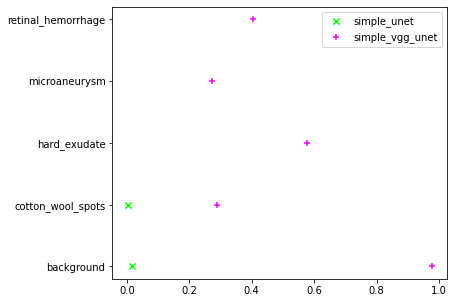

In [52]:
ev_stage_1.stage_five(path="./experiment_results/stage_1/unet_vs_vgg.png")

### Resnet Comparison

In [53]:
unet_simp_path = "./model_weights/stage_1/simple_unet.pth"
unet_simp = UNet(num_classes=5, d_in=3,filters=[64, 128, 256, 512, 1024], simple=True).to(device)
unet_state_dict = torch.load(unet_simp_path, map_location=device)
unet_simp.load_state_dict(unet_state_dict)

res_simp_path = "./model_weights/stage_1/simple_resunet.pth"
res_simp = ResNetUNet(5, simple=True).to(device)
res_simp_state_dict = torch.load(res_simp_path, map_location=device)
res_simp.load_state_dict(res_simp_state_dict)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

In [54]:
model_dict = {
    "simple_unet" : unet_simp,
    "simple_resnet_unet" : res_simp
}

color_dict = {
    1 : np.array([[80, 230, 147]]),
    2 : np.array([[245, 234, 133]]),
    3 : np.array([[224, 20, 20]]),
    4 : np.array([[64, 22, 217]])
} 

class_dict = ["background"] + classes

In [55]:
ev_stage_1b = EvalPipeline(dataloader=test_dl, n=5, model_dict=model_dict, class_dict=class_dict, color_dict=color_dict)

100%|██████████| 40/40 [00:07<00:00,  5.44it/s]


/tmp/ipykernel_57/3307293890.py:320: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2 * prec * recall) / (prec + recall)


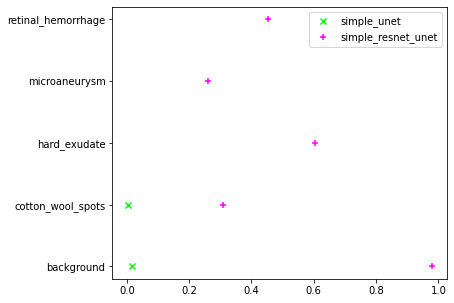

In [56]:
ev_stage_1b.stage_five(path="./experiment_results/stage_1/unet_vs_res.png")

### Efficient Net Comparison

In [59]:
unet_simp_path = "./model_weights/stage_1/simple_unet.pth"
unet_simp = UNet(num_classes=5, d_in=3,filters=[64, 128, 256, 512, 1024], simple=True).to(device)
unet_state_dict = torch.load(unet_simp_path, map_location=device)
unet_simp.load_state_dict(unet_state_dict)

b4_simp_path = "./model_weights/stage_1/simple_effunet.pth"
b4_simp = EfficientNetUNet(5, simple=True).to(device)
b4_state_dict = torch.load(b4_simp_path, map_location=device)
b4_simp.load_state_dict(b4_state_dict)

<All keys matched successfully>

In [60]:
model_dict = {
    "simple_unet" : unet_simp,
    "simple_efficientnet_unet" : b4_simp
}

color_dict = {
    1 : np.array([[80, 230, 147]]),
    2 : np.array([[245, 234, 133]]),
    3 : np.array([[224, 20, 20]]),
    4 : np.array([[64, 22, 217]])
} 

class_dict = ["background"] + classes

In [61]:
ev_stage_1c = EvalPipeline(test_dl, 5, model_dict, class_dict, color_dict)

100%|██████████| 40/40 [00:06<00:00,  6.64it/s]


/tmp/ipykernel_57/3307293890.py:320: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2 * prec * recall) / (prec + recall)


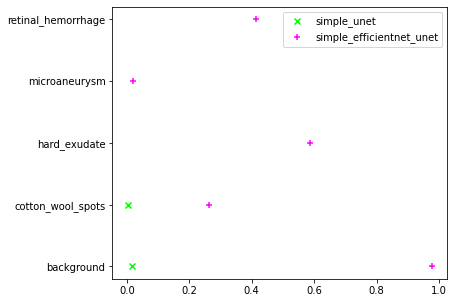

In [62]:
ev_stage_1c.stage_five(path="./experiment_results/stage_1/unet_vs_effnet.png")

## Stage 2